# 032623 - Semi-supervised learning for classification with clustering-assisted labelling.

## Background

Semi-supervised learning is a type of machine learning where only some of the data is labeled and the goal is to use the labeled data to make predictions on the unlabeled data. Clustering-assisted labeling is a technique used in semi-supervised learning where clustering is used to group similar data points together and then assign labels to these groups.

The basic idea behind clustering-assisted labeling is to use clustering to group similar data points together, and then use the labeled data to assign labels to the clusters. Once the clusters have been labeled, the labels can be propagated to the unlabeled data points in the same cluster.

The advantage of using clustering-assisted labeling is that it allows us to make use of the structure in the data to generate labels for the unlabeled data. This can be particularly useful in cases where labeling the data manually is time-consuming or expensive.

In the context of algo trading, clustering-assisted labeling can be used to create labels for financial data, such as stock prices or exchange rates. The clustering algorithm can be used to group similar data points together based on their attributes, such as volatility or volume. The labeled data can then be used to train a machine learning algorithm to make predictions on the unlabeled data.

To-Do:
- [ ] Redo the clustering parameters to stop in January 2023. 
- [ ] Tweak Aglo w/o overfitting
- [ ] Calculate Sortino and Sharpe Ratio 

---
## 0. Imports

In [684]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../../functions_library')

from functions import ROC, model_selection, Backtesting

#import sklearn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import sklearn.ensemble

# Classification Metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc #plot_roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ML models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb

# libraries for Shapely analysis
import shap 

# Visualization libraries
import matplotlib.pyplot as plt
import hvplot.pandas

seed = 42

---
## 1. Data Loading

Read the CSV file into Pandas DataFrame

In [685]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("../../Resources/ETHUSDT-1h-data.csv"), 
    index_col="timestamp", 
    infer_datetime_format=True, 
    parse_dates=True
)

trading_df = trading_df.drop(["close_time","quote_av","trades","tb_base_av","tb_quote_av","ignore"], axis =1)

# Review the DataFrame
trading_df.head()

open    high    low   close     volume
timestamp                                                    
2017-08-17 04:00:00  301.13  302.57  298.0  301.61  125.66877
2017-08-17 05:00:00  301.61  303.28  300.0  303.10  377.67246
2017-08-17 06:00:00  302.40  304.44  301.9  302.68  303.86672
2017-08-17 07:00:00  302.68  307.96  302.6  307.96  754.74510
2017-08-17 08:00:00  307.95  309.97  307.0  308.62  150.75029

In [686]:
# drop duplicate index label
trading_df = trading_df[~trading_df.index.duplicated(keep='first')]

In [687]:
trading_df.tail()

open     high      low    close      volume
timestamp                                                          
2023-03-26 20:00:00  1765.83  1769.69  1754.39  1760.35  12737.3298
2023-03-26 21:00:00  1760.35  1764.31  1757.01  1764.12   6148.1795
2023-03-26 22:00:00  1764.11  1779.22  1761.22  1776.08  13690.1885
2023-03-26 23:00:00  1776.07  1783.70  1772.71  1773.88  14628.1402
2023-03-27 00:00:00  1773.88  1780.48  1771.95  1778.64  14104.6269

Add a daily return values column to the DataFrame

In [60]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

open    high     low   close     volume  actual_returns
timestamp                                                                     
2017-08-17 06:00:00  302.40  304.44  301.90  302.68  303.86672       -0.001386
2017-08-17 07:00:00  302.68  307.96  302.60  307.96  754.74510        0.017444
2017-08-17 08:00:00  307.95  309.97  307.00  308.62  150.75029        0.002143
2017-08-17 09:00:00  308.62  312.00  308.62  310.00  469.27879        0.004472
2017-08-17 10:00:00  310.00  310.97  308.54  309.30  284.39140       -0.002258

open     high      low    close      volume  \
timestamp                                                             
2023-03-26 20:00:00  1765.83  1769.69  1754.39  1760.35  12737.3298   
2023-03-26 21:00:00  1760.35  1764.31  1757.01  1764.12   6148.1795   
2023-03-26 22:00:00  1764.11  1779.22  1761.22  1776.08  13690.1885   
2023-03-26 23:00:00  1776.07  1783.70  1772.71  1773.88  14628.1402   
2023-03-27 00:00:00  1773.88  1780.48  1771.95  1778.64  14104.6269   

                     actual_returns  
timestamp                            
2023-03-26 20:00:00       -0.003098  
2023-03-26 21:00:00        0.002142  
2023-03-26 22:00:00        0.006780  
2023-03-26 23:00:00       -0.001239  
2023-03-27 00:00:00        0.002683

In [61]:
# Import the OHLCV dataset into a Pandas Dataframe
fng_df = pd.read_csv(
    Path("../../Resources/altme_fng.csv"), 
    #Path("../../Resources/crypto_fear_and_greed_index.csv"), 
    index_col="date", 
    #index_col="timestamp", 
    infer_datetime_format=True, 
    parse_dates=True,
    dayfirst=True,
    skiprows = [0,1]
)

#timestamp,value,value_classification
#resample to 1H timeframe
fng_df = fng_df.resample('1H').ffill()

# fill the fng_classification column with the same value for each day of 24H
#fng_df['value_classification'] = fng_df['value_classification'].fillna(method='ffill')
fng_df['fng_classification'] = fng_df['fng_classification'].fillna(method='ffill')



# Review the DataFrame
fng_df.head()

fng_value fng_classification
date                                             
2018-02-01 00:00:00         30               Fear
2018-02-01 01:00:00         30               Fear
2018-02-01 02:00:00         30               Fear
2018-02-01 03:00:00         30               Fear
2018-02-01 04:00:00         30               Fear

In [62]:
fng_df.tail()

fng_value fng_classification
date                                             
2023-03-05 20:00:00         47            Neutral
2023-03-05 21:00:00         47            Neutral
2023-03-05 22:00:00         47            Neutral
2023-03-05 23:00:00         47            Neutral
2023-03-06 00:00:00         48            Neutral

In [63]:
# rename column 'B' to 'C'
fng_df = fng_df.rename(columns={'value_classification': 'fng_classification'})
fng_df = fng_df.rename(columns={'value': 'fng_value'})


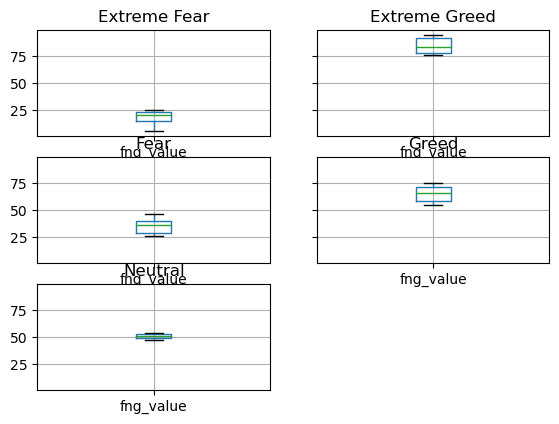

In [64]:
# Group by fng_classification and display boxplots for other columns
fng_df.groupby("fng_classification").boxplot(column=["fng_value"])

# Show the plot
plt.show()

In [65]:
merged_df = pd.merge(fng_df, trading_df, how='inner', left_index=True, right_index=True)

In [66]:
merged_df.dropna()

fng_value fng_classification     open     high      low  \
2018-02-01 00:00:00         30               Fear  1125.96  1137.99  1120.56   
2018-02-01 01:00:00         30               Fear  1132.00  1140.89  1125.01   
2018-02-01 02:00:00         30               Fear  1134.07  1154.99  1134.07   
2018-02-01 03:00:00         30               Fear  1150.51  1164.99  1125.01   
2018-02-01 04:00:00         30               Fear  1140.00  1154.72  1130.18   
...                        ...                ...      ...      ...      ...   
2023-03-05 20:00:00         47            Neutral  1566.22  1570.58  1565.80   
2023-03-05 21:00:00         47            Neutral  1569.55  1579.45  1558.01   
2023-03-05 22:00:00         47            Neutral  1572.05  1572.06  1560.54   
2023-03-05 23:00:00         47            Neutral  1565.59  1566.73  1556.15   
2023-03-06 00:00:00         48            Neutral  1564.57  1569.48  1559.02   

                       close       volume  actual_returns  
2018-02-01 00:00:00  1132.00   3465.84651        0.006392  
2018-02-01 01:00:00  1135.00   4149.14991        0.002650  
2018-02-01 02:00:00  1150.50   4828.74525        0.013656  
2018-02-01 03:00:00  1140.00   7622.31840       -0.009126  
2018-02-01 04:00:00  1152.51   3899.48396        0.010974  
...                      ...          ...             ...  
2023-03-05 20:00:00  1569.54   6526.43370        0.002120  
2023-03-05 21:00:00  1572.06  25711.93000        0.001606  
2023-03-05 22:00:00  1565.59  27737.02560       -0.004116  
2023-03-05 23:00:00  1564.58  16562.69490       -0.000645  
2023-03-06 00:00:00  1567.90  10726.70470        0.002122  

[44497 rows x 8 columns]

In [67]:
merged_df

fng_value fng_classification     open     high      low  \
2018-02-01 00:00:00         30               Fear  1125.96  1137.99  1120.56   
2018-02-01 01:00:00         30               Fear  1132.00  1140.89  1125.01   
2018-02-01 02:00:00         30               Fear  1134.07  1154.99  1134.07   
2018-02-01 03:00:00         30               Fear  1150.51  1164.99  1125.01   
2018-02-01 04:00:00         30               Fear  1140.00  1154.72  1130.18   
...                        ...                ...      ...      ...      ...   
2023-03-05 20:00:00         47            Neutral  1566.22  1570.58  1565.80   
2023-03-05 21:00:00         47            Neutral  1569.55  1579.45  1558.01   
2023-03-05 22:00:00         47            Neutral  1572.05  1572.06  1560.54   
2023-03-05 23:00:00         47            Neutral  1565.59  1566.73  1556.15   
2023-03-06 00:00:00         48            Neutral  1564.57  1569.48  1559.02   

                       close       volume  actual_returns  
2018-02-01 00:00:00  1132.00   3465.84651        0.006392  
2018-02-01 01:00:00  1135.00   4149.14991        0.002650  
2018-02-01 02:00:00  1150.50   4828.74525        0.013656  
2018-02-01 03:00:00  1140.00   7622.31840       -0.009126  
2018-02-01 04:00:00  1152.51   3899.48396        0.010974  
...                      ...          ...             ...  
2023-03-05 20:00:00  1569.54   6526.43370        0.002120  
2023-03-05 21:00:00  1572.06  25711.93000        0.001606  
2023-03-05 22:00:00  1565.59  27737.02560       -0.004116  
2023-03-05 23:00:00  1564.58  16562.69490       -0.000645  
2023-03-06 00:00:00  1567.90  10726.70470        0.002122  

[44497 rows x 8 columns]

---
## 2. Feature Engineering

# drop duplicate index label
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

In [68]:
import finta as ft
from finta import TA
import talib

ohlcv_df = merged_df

# List of time periods to use for Moving Averages calculation
timeperiods = [5,7,14,20,30,50,70,100,150,200]

df_eng = ohlcv_df.copy()

# Calculate SMAs and add them to the DataFrame
for t in timeperiods:
    #tsma = TA.SMA(df_eng t).shift(1)
    sma = TA.SMA(df_eng,t)
    ema = TA.EMA(df_eng,t)
    atr = TA.ATR(df_eng,t)  #Average True Range
    adx = TA.ADX(df_eng,t) 
    rsi = TA.RSI(df_eng,t)
    hma = TA.HMA(df_eng,t)
    vama = TA.VAMA(df_eng,t)
 
    # calculate the Force Index
    force_index = pd.Series(df_eng['close'].diff(1) * df_eng['volume'], index=df_eng.index)
    force_ema = force_index.ewm(span=t, min_periods=0, adjust=True, ignore_na=False).mean()    
    
    #df['force_index'] = force_index
    #df[f'force_index_ema_{t}'] = force_ema # add the Force Index and its EMA to the DataFrame
    #df[f'TSMA_{t}'] = tsma
    df_eng[f'SMA_{t}'] = sma
    df_eng[f'EMA_{t}'] = ema
    df_eng[f'HMA_{t}'] = hma
    df_eng[f'VAMA_{t}'] = vama
    df_eng[f'ATR_{t}'] = atr
    df_eng[f'ADX_{t}'] = adx
    df_eng[f'RSI_{t}'] = rsi
    
    
# Calculate the Parabolic SAR
#sar = TA.PSAR(df)

# Add the SAR values and trend direction to the DataFrame
#df['sar'] = sar['psar']
#df['psarbear'] = sar['psarbear']
#df['psarbull'] = sar['psarbull']

df_eng['UO'] = TA.UO(df_eng)

# Adding Awesome Indicator (AO)
df_eng['AO'] = TA.AO(df_eng)
df_eng['OBV'] =TA.OBV(df_eng)

# Adding Chaikin Indicator 
df_eng['CHAIKIN'] = TA.CHAIKIN(df_eng)

# Adding Bollinger Bands
df_eng[['BB_UPPER','BB_MED','BB_LOWER']] =TA.BBANDS(df_eng)

# Calculate the Keltner Channel with TALIB
#df[['KC_UPPER','KC_MED','KC_LOWER']] = TA.KC(df)

# calculate Commodity Channel Index (CCI)
df_eng['cci'] = TA.CCI(df_eng)

# assuming you have OHLCV data in a pandas dataframe called "df"
#volume_momentum = talib.MOM(df['volume'])

In [70]:
# check for duplicate index labels
print(df_eng.index.duplicated().any())

False


In [71]:
# drop duplicate index label
df_eng = df_eng[~df_eng.index.duplicated(keep='first')]


In [72]:
df_eng.dropna()

fng_value fng_classification     open     high      low  \
2018-02-18 23:00:00         63              Greed   917.09   918.55   907.75   
2018-02-19 00:00:00         67              Greed   911.00   922.94   906.04   
2018-02-19 01:00:00         67              Greed   922.39   933.50   917.75   
2018-02-19 02:00:00         67              Greed   928.19   929.06   912.21   
2018-02-19 03:00:00         67              Greed   925.89   928.00   917.10   
...                        ...                ...      ...      ...      ...   
2023-03-05 20:00:00         47            Neutral  1566.22  1570.58  1565.80   
2023-03-05 21:00:00         47            Neutral  1569.55  1579.45  1558.01   
2023-03-05 22:00:00         47            Neutral  1572.05  1572.06  1560.54   
2023-03-05 23:00:00         47            Neutral  1565.59  1566.73  1556.15   
2023-03-06 00:00:00         48            Neutral  1564.57  1569.48  1559.02   

                       close       volume  actual_returns     SMA_5  \
2018-02-18 23:00:00   911.00   6721.04031       -0.007074   927.274   
2018-02-19 00:00:00   921.76   5083.44557        0.011811   922.698   
2018-02-19 01:00:00   929.00   3830.15285        0.007855   921.598   
2018-02-19 02:00:00   925.90   3512.92499       -0.003337   921.030   
2018-02-19 03:00:00   921.43   2661.29722       -0.004828   921.818   
...                      ...          ...             ...       ...   
2023-03-05 20:00:00  1569.54   6526.43370        0.002120  1568.564   
2023-03-05 21:00:00  1572.06  25711.93000        0.001606  1568.924   
2023-03-05 22:00:00  1565.59  27737.02560       -0.004116  1568.322   
2023-03-05 23:00:00  1564.58  16562.69490       -0.000645  1567.598   
2023-03-06 00:00:00  1567.90  10726.70470        0.002122  1567.934   

                           EMA_5  ...   ADX_200    RSI_200         UO  \
2018-02-18 23:00:00   922.858166  ...  9.394577  49.654668  59.387041   
2018-02-19 00:00:00   922.492111  ...  9.390300  49.975991  59.703989   
2018-02-19 01:00:00   924.661407  ...  9.366996  50.190969  58.511535   
2018-02-19 02:00:00   925.074271  ...  9.352467  50.098320  58.171079   
2018-02-19 03:00:00   923.859514  ...  9.338092  49.964661  59.022664   
...                          ...  ...       ...        ...        ...   
2023-03-05 20:00:00  1568.561983  ...  6.177714  47.830113  43.658669   
2023-03-05 21:00:00  1569.727989  ...  6.185797  47.959404  54.556130   
2023-03-05 22:00:00  1568.348659  ...  6.193841  47.654661  54.644861   
2023-03-05 23:00:00  1567.092439  ...  6.204318  47.607201  57.033462   
2023-03-06 00:00:00  1567.361626  ...  6.212924  47.779016  61.821881   

                            AO           OBV      CHAIKIN     BB_UPPER  \
2018-02-18 23:00:00 -15.846618 -1.821713e+05  1592.367588   954.592387   
2018-02-19 00:00:00 -19.378588 -1.770879e+05  2174.456147   950.742237   
2018-02-19 01:00:00 -20.752765 -1.732577e+05  2737.199024   950.525470   
2018-02-19 02:00:00 -20.606882 -1.767706e+05  3417.085862   950.562403   
2018-02-19 03:00:00 -19.321471 -1.794319e+05  3210.560786   949.838141   
...                        ...           ...          ...          ...   
2023-03-05 20:00:00   1.069971 -2.137735e+06 -1074.804770  1576.597091   
2023-03-05 21:00:00   0.971912 -2.112023e+06  2181.932360  1573.090699   
2023-03-05 22:00:00   0.332147 -2.139760e+06  2228.021176  1573.190514   
2023-03-05 23:00:00  -0.814500 -2.156322e+06  5172.426215  1573.503375   
2023-03-06 00:00:00  -1.071971 -2.145596e+06  8288.686184  1573.125944   

                        BB_MED     BB_LOWER         cci  
2018-02-18 23:00:00   929.0245   903.456613 -133.569399  
2018-02-19 00:00:00   927.4950   904.247763  -91.552291  
2018-02-19 01:00:00   928.2925   906.059530   -4.313610  
2018-02-19 02:00:00   928.4140   906.265597  -42.381210  
2018-02-19 03:00:00   927.7240   905.609859  -40.287643  
...                        ...          ...         ...  
2023-03-05 20:00:00  1569.7560  156

In [73]:
# check for duplicate index labels
print(df_eng.index.duplicated().any())

False


In [74]:
# calculate the Ichimoku Kinko Hyo indicator
# Calculate the conversion line
nine_period_high = df_eng['high'].rolling(window=9).max()
nine_period_low = df_eng['low'].rolling(window=9).min()
df_eng['tenkan_sen'] = (nine_period_high + nine_period_low) / 2

# Calculate the base line
periods = 26
twenty_six_period_high = df_eng['high'].rolling(window=periods).max()
twenty_six_period_low = df_eng['low'].rolling(window=periods).min()
df_eng['kijun_sen'] = (twenty_six_period_high + twenty_six_period_low) / 2

# Calculate the leading span A
df_eng['senkou_span_a'] = ((df_eng['tenkan_sen'] + df_eng['kijun_sen']) / 2).shift(periods=periods)

# Calculate the leading span B
periods2 = 52
fifty_two_period_high = df_eng['high'].rolling(window=periods2).max()
fifty_two_period_low = df_eng['low'].rolling(window=periods2).min()
df_eng['senkou_span_b'] = ((fifty_two_period_high + fifty_two_period_low) / 2).shift(periods=periods)

# Calculate the lagging span
df_eng['chikou_span'] = df_eng['close'].shift(periods=-periods)


#### Add a daily return values column to the DataFrame

In [75]:
# Calculate the daily returns using the closing prices and the pct_change function
df_eng["actual_returns"] = df_eng["close"].pct_change()

# Drop all NaN values from the DataFrame
#df_eng = df_eng.dropna()

# Review the DataFrame
df_eng.head()

fng_value fng_classification     open     high      low  \
2018-02-01 00:00:00         30               Fear  1125.96  1137.99  1120.56   
2018-02-01 01:00:00         30               Fear  1132.00  1140.89  1125.01   
2018-02-01 02:00:00         30               Fear  1134.07  1154.99  1134.07   
2018-02-01 03:00:00         30               Fear  1150.51  1164.99  1125.01   
2018-02-01 04:00:00         30               Fear  1140.00  1154.72  1130.18   

                       close      volume  actual_returns     SMA_5  \
2018-02-01 00:00:00  1132.00  3465.84651             NaN       NaN   
2018-02-01 01:00:00  1135.00  4149.14991        0.002650       NaN   
2018-02-01 02:00:00  1150.50  4828.74525        0.013656       NaN   
2018-02-01 03:00:00  1140.00  7622.31840       -0.009126       NaN   
2018-02-01 04:00:00  1152.51  3899.48396        0.010974  1142.002   

                           EMA_5  ...  CHAIKIN  BB_UPPER  BB_MED  BB_LOWER  \
2018-02-01 00:00:00  1132.000000  ...      NaN       NaN     NaN       NaN   
2018-02-01 01:00:00  1133.800000  ...      NaN       NaN     NaN       NaN   
2018-02-01 02:00:00  1141.710526  ...      NaN       NaN     NaN       NaN   
2018-02-01 03:00:00  1141.000000  ...      NaN       NaN     NaN       NaN   
2018-02-01 04:00:00  1145.418531  ...      NaN       NaN     NaN       NaN   

                            cci  tenkan_sen  kijun_sen  senkou_span_a  \
2018-02-01 00:00:00         NaN         NaN        NaN            NaN   
2018-02-01 01:00:00   66.666667         NaN        NaN            NaN   
2018-02-01 02:00:00  100.000000         NaN        NaN            NaN   
2018-02-01 03:00:00   50.347800         NaN        NaN            NaN   
2018-02-01 04:00:00   61.653937         NaN        NaN            NaN   

                     senkou_span_b  chikou_span  
2018-02-01 00:00:00            NaN      1003.56  
2018-02-01 01:00:00            NaN       977.97  
2018-02-01 02:00:00            NaN       972.00  
2018-02-01 03:00:00            NaN       945.10  
2018-02-01 04:00:00            NaN       950.01  

[5 rows x 91 columns]

In [76]:
df_eng

fng_value fng_classification     open     high      low  \
2018-02-01 00:00:00         30               Fear  1125.96  1137.99  1120.56   
2018-02-01 01:00:00         30               Fear  1132.00  1140.89  1125.01   
2018-02-01 02:00:00         30               Fear  1134.07  1154.99  1134.07   
2018-02-01 03:00:00         30               Fear  1150.51  1164.99  1125.01   
2018-02-01 04:00:00         30               Fear  1140.00  1154.72  1130.18   
...                        ...                ...      ...      ...      ...   
2023-03-05 20:00:00         47            Neutral  1566.22  1570.58  1565.80   
2023-03-05 21:00:00         47            Neutral  1569.55  1579.45  1558.01   
2023-03-05 22:00:00         47            Neutral  1572.05  1572.06  1560.54   
2023-03-05 23:00:00         47            Neutral  1565.59  1566.73  1556.15   
2023-03-06 00:00:00         48            Neutral  1564.57  1569.48  1559.02   

                       close       volume  actual_returns     SMA_5  \
2018-02-01 00:00:00  1132.00   3465.84651             NaN       NaN   
2018-02-01 01:00:00  1135.00   4149.14991        0.002650       NaN   
2018-02-01 02:00:00  1150.50   4828.74525        0.013656       NaN   
2018-02-01 03:00:00  1140.00   7622.31840       -0.009126       NaN   
2018-02-01 04:00:00  1152.51   3899.48396        0.010974  1142.002   
...                      ...          ...             ...       ...   
2023-03-05 20:00:00  1569.54   6526.43370        0.002120  1568.564   
2023-03-05 21:00:00  1572.06  25711.93000        0.001606  1568.924   
2023-03-05 22:00:00  1565.59  27737.02560       -0.004116  1568.322   
2023-03-05 23:00:00  1564.58  16562.69490       -0.000645  1567.598   
2023-03-06 00:00:00  1567.90  10726.70470        0.002122  1567.934   

                           EMA_5  ...      CHAIKIN     BB_UPPER     BB_MED  \
2018-02-01 00:00:00  1132.000000  ...          NaN          NaN        NaN   
2018-02-01 01:00:00  1133.800000  ...          NaN          NaN        NaN   
2018-02-01 02:00:00  1141.710526  ...          NaN          NaN        NaN   
2018-02-01 03:00:00  1141.000000  ...          NaN          NaN        NaN   
2018-02-01 04:00:00  1145.418531  ...          NaN          NaN        NaN   
...                          ...  ...          ...          ...        ...   
2023-03-05 20:00:00  1568.561983  ... -1074.804770  1576.597091  1569.7560   
2023-03-05 21:00:00  1569.727989  ...  2181.932360  1573.090699  1569.2535   
2023-03-05 22:00:00  1568.348659  ...  2228.021176  1573.190514  1569.2135   
2023-03-05 23:00:00  1567.092439  ...  5172.426215  1573.503375  1569.0500   
2023-03-06 00:00:00  1567.361626  ...  8288.686184  1573.125944  1568.8515   

                        BB_LOWER         cci  tenkan_sen  kijun_sen  \
2018-02-01 00:00:00          NaN         NaN         NaN        NaN   
2018-02-01 01:00:00          NaN   66.666667         NaN        NaN   
2018-02-01 02:00:00          NaN  100.000000         NaN        NaN   
2018-02-01 03:00:00          NaN   50.347800         NaN        NaN   
2018-02-01 04:00:00          NaN   61.653937         NaN        NaN   
...                          ...         ...         ...        ...   
2023-03-05 20:00:00  1562.914909  -46.183031    1568.655   1568.945   
2023-03-05 21:00:00  1565.416301   30.898810    1568.730   1568.945   
2023-03-05 22:00:00  1565.236486 -165.615562    1568.730   1569.020   
2023-03-05 23:00:00  1564.596625 -264.411220    1567.800   1570.910   
2023-03-06 00:00:00  1564.577056 -121.690305    1567.800   1570.910   

                     senkou_span_a  senkou_span_b  chikou_span  
2018-02-01 00:00:00            NaN            NaN      1003.56  
2018-02-01 01:00:00            NaN            NaN       977.97  
2018-02-01 02:00:00            NaN            NaN       972.00  
2018-02-01 03:00:00            NaN            NaN       945.10  
2018-02-01 04:00:00            NaN            NaN       950.01  
...                        

---
## 3. Pre-Processing
### 3.1 Remove highly-correlated features

In [77]:
df_feats = df_eng.copy()
df_feats = df_feats.drop(["open","high","low","fng_value"], axis =1)

In [78]:

# Calculate correlation matrix
# calculate the correlation matrix of the features
corr_matrix = df_feats.corr()

# set the threshold for correlation value
corr_threshold = 0.45

# find the highly correlated features and drop them from the dataframe
high_corr_features = np.where(corr_matrix.abs() > corr_threshold)
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
df_feats.drop([col[1] for col in high_corr_features], axis=1, inplace=True)

# select the remaining features with low correlation
low_corr_features = df_feats.columns.tolist()

# print the low correlated features
print(low_corr_features)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


['fng_classification', 'close', 'volume', 'actual_returns', 'ADX_5']


In [79]:
df_feats = df_feats[['fng_classification', 'volume', 'ADX_5']]

In [80]:
# replace spaces with underscores in the categorical column
df_feats["fng_classification"] = df_feats["fng_classification"].str.replace("Extreme ", "Hi_")

In [81]:
df_feats["fng_classification"].value_counts()

Fear        15311
Hi_Fear     12716
Greed        7739
Hi_Greed     4422
Neutral      4309
Name: fng_classification, dtype: int64

In [82]:
# Get dummy variables for the categorical column
dummy_df = pd.get_dummies(df_feats['fng_classification'], prefix='fng')

# Concatenate the original DataFrame with the dummy-encoded DataFrame
df_encoded = pd.concat([df_feats, dummy_df], axis=1)

# Drop the original categorical column (optional)
df_encoded.drop('fng_classification', axis=1, inplace=True)

df_encoded

volume      ADX_5  fng_Fear  fng_Greed  fng_Hi_Fear  \
2018-02-01 00:00:00   3465.84651        NaN         1          0            0   
2018-02-01 01:00:00   4149.14991        NaN         1          0            0   
2018-02-01 02:00:00   4828.74525        NaN         1          0            0   
2018-02-01 03:00:00   7622.31840        NaN         1          0            0   
2018-02-01 04:00:00   3899.48396        NaN         1          0            0   
...                          ...        ...       ...        ...          ...   
2023-03-05 20:00:00   6526.43370  25.495125         0          0            0   
2023-03-05 21:00:00  25711.93000  25.333099         0          0            0   
2023-03-05 22:00:00  27737.02560  25.203478         0          0            0   
2023-03-05 23:00:00  16562.69490  20.286327         0          0            0   
2023-03-06 00:00:00  10726.70470  18.798839         0          0            0   

                     fng_Hi_Greed  fng_Neutral  
2018-02-01 00:00:00             0            0  
2018-02-01 01:00:00             0            0  
2018-02-01 02:00:00             0            0  
2018-02-01 03:00:00             0            0  
2018-02-01 04:00:00             0            0  
...                           ...          ...  
2023-03-05 20:00:00             0            1  
2023-03-05 21:00:00             0            1  
2023-03-05 22:00:00             0            1  
2023-03-05 23:00:00             0            1  
2023-03-06 00:00:00             0            1  

[44497 rows x 7 columns]

In [83]:
df_encoded = df_encoded.dropna()

In [84]:
df_encoded

volume       ADX_5  fng_Fear  fng_Greed  \
2018-02-01 05:00:00   3462.28586  100.000000         1          0   
2018-02-01 06:00:00   3400.69303   50.133579         1          0   
2018-02-01 07:00:00   2589.27888   39.437213         1          0   
2018-02-01 08:00:00  12753.77711   53.920963         1          0   
2018-02-01 09:00:00   8388.78259   62.331328         1          0   
...                          ...         ...       ...        ...   
2023-03-05 20:00:00   6526.43370   25.495125         0          0   
2023-03-05 21:00:00  25711.93000   25.333099         0          0   
2023-03-05 22:00:00  27737.02560   25.203478         0          0   
2023-03-05 23:00:00  16562.69490   20.286327         0          0   
2023-03-06 00:00:00  10726.70470   18.798839         0          0   

                     fng_Hi_Fear  fng_Hi_Greed  fng_Neutral  
2018-02-01 05:00:00            0             0            0  
2018-02-01 06:00:00            0             0            0  
2018-02-01 07:00:00            0             0            0  
2018-02-01 08:00:00            0             0            0  
2018-02-01 09:00:00            0             0            0  
...                          ...           ...          ...  
2023-03-05 20:00:00            0             0            1  
2023-03-05 21:00:00            0             0            1  
2023-03-05 22:00:00            0             0            1  
2023-03-05 23:00:00            0             0            1  
2023-03-06 00:00:00            0             0            1  

[44492 rows x 7 columns]

---
### 4 Clustering

> values that works well: dbscan = DBSCAN(eps=3, min_samples=600)

In [85]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(df_encoded)

# Create and fit the DBSCAN model
dbscan = DBSCAN(eps=3, min_samples=200)
clusters = dbscan.fit_predict(X)

# Add the cluster labels to the original dataframe
df_encoded['cluster'] = clusters


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [86]:
unique_clusters = df_encoded['cluster'].unique()
print(unique_clusters)

[ 0  1  2  3 -1  4]


In [87]:
df_encoded[['close','actual_returns']] = df_eng[['close','actual_returns']]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


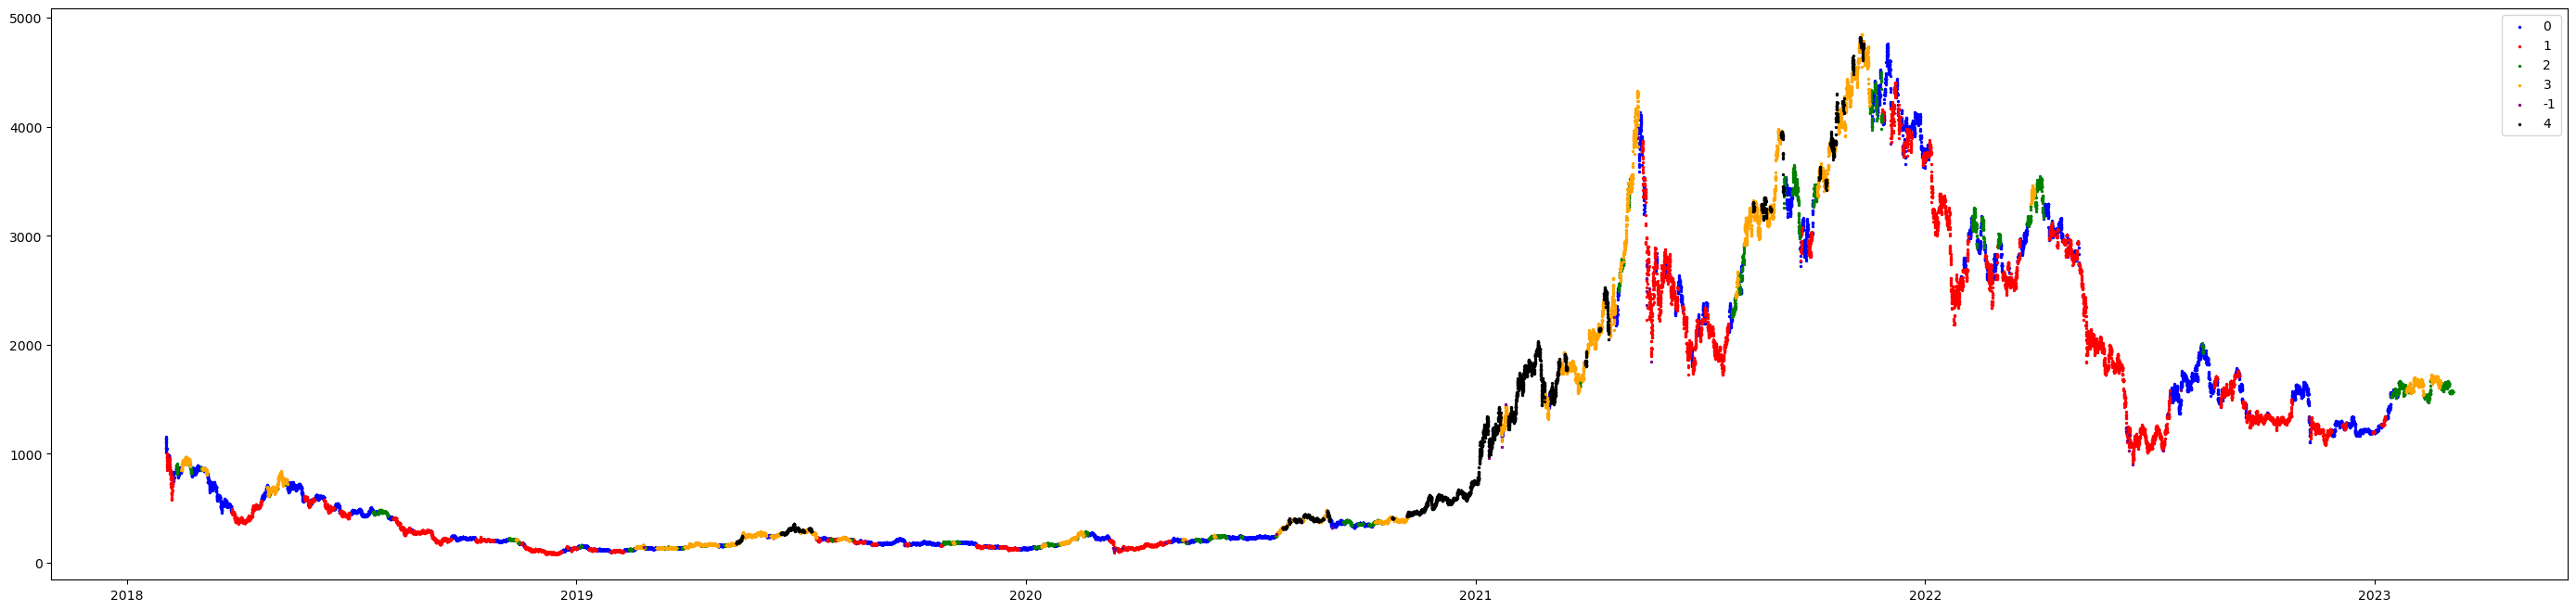

In [88]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 8))
for label, color in zip(df_encoded['cluster'].unique(), ['blue', 'red', 'green', 'orange', 'purple','black','grey','yellow','magenta','cyan']):
    mask = df_encoded['cluster'] == label
    ax.scatter(df_encoded.index[mask], df_encoded['close'][mask], label=label, c=color, s=2)
ax.legend()
plt.show()

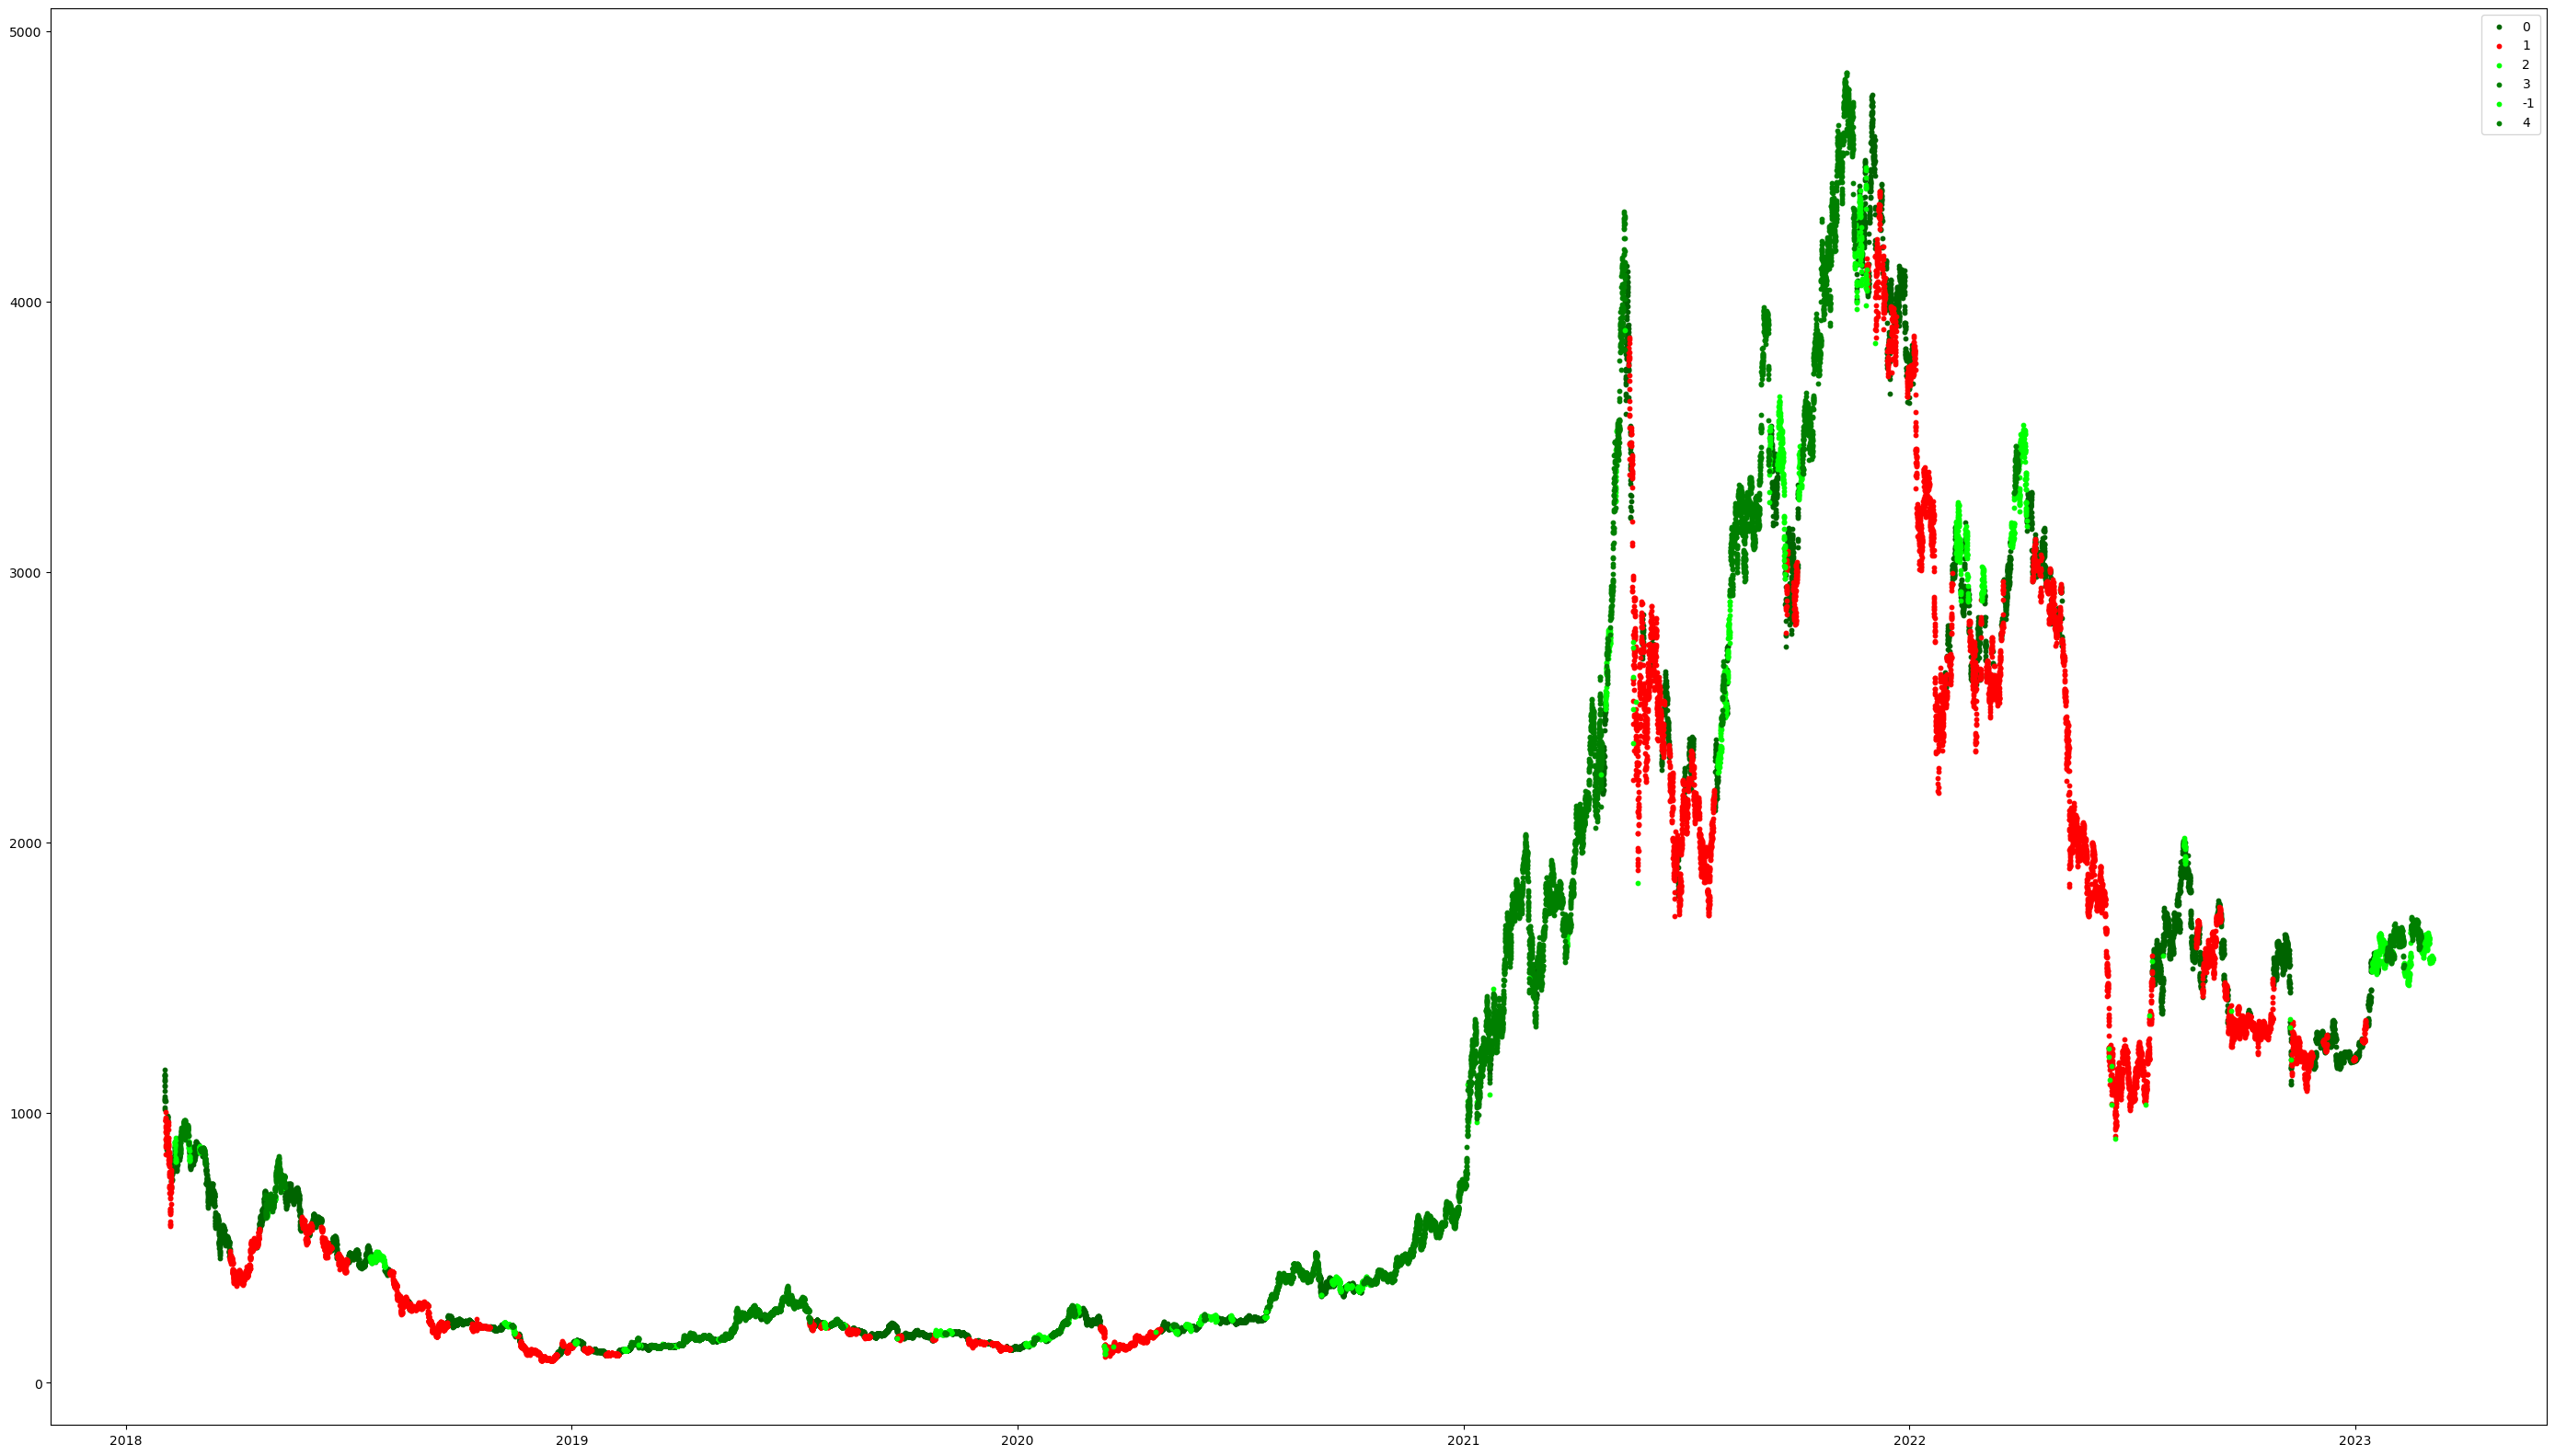

In [110]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 20))
for label, color in zip(df_encoded['cluster'].unique(), ['darkgreen', 'red', 'lime', 'green', 'lime','green']):
    mask = df_encoded['cluster'] == label
    ax.scatter(df_encoded.index[mask], df_encoded['close'][mask], label=label, c=color, s=10)
ax.legend()
plt.show()

In [90]:
# Display the plot inline in Jupyter Lab
%matplotlib inline

# Create the scatter plot using hvplot.scatter
scatter = df_encoded.hvplot.scatter(x='index', y='close', by='cluster', legend='top')

# Set the plot options
scatter.opts(
    title='Time Series with Clusters',
    xlabel='Date',
    ylabel='Close Price',
    height=500,
    width=1000
)

# Show the plot
hvplot.show(scatter)

Launching server at http://localhost:50751


In [413]:
df_eda  = df_encoded


In [414]:
df_eda [['fng_value','fng_classification','actual_returns']] = df_eng [['fng_value','fng_classification','actual_returns']]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [415]:
df_eda.columns

Index(['volume', 'ADX_5', 'fng_Fear', 'fng_Greed', 'fng_Hi_Fear',
       'fng_Hi_Greed', 'fng_Neutral', 'cluster', 'close', 'actual_returns',
       'fng_value', 'fng_classification', 'signal', 'Position',
       'Entry/Exit Position', 'Portfolio Holdings', 'Portfolio Cash',
       'Portfolio Total', 'Portfolio Daily Returns',
       'Portfolio Cumulative Returns'],
      dtype='object')

<Axes: xlabel='cluster', ylabel='fng_value'>

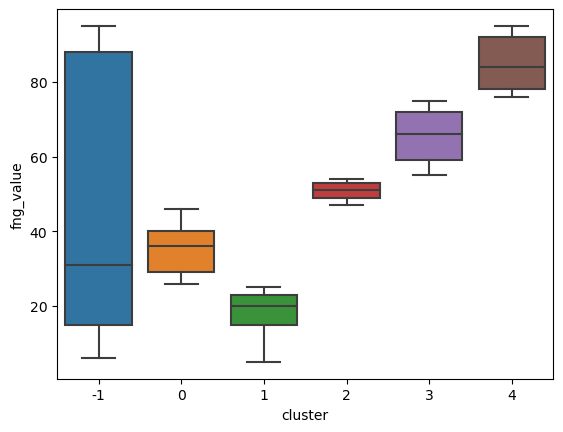

In [416]:
import seaborn as sns

# create a new DataFrame with just the relevant columns
cluster_df = df_eda[['cluster', 'fng_value', 'actual_returns']]

# create boxplots of fng_value and actual_returns for each cluster
sns.boxplot(data=cluster_df, x='cluster', y='fng_value')


<Axes: xlabel='cluster', ylabel='actual_returns'>

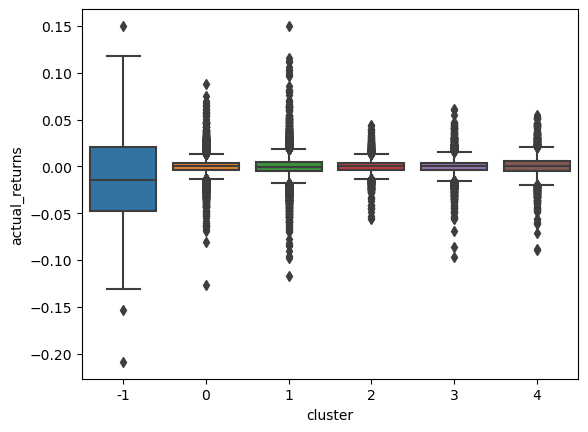

In [417]:
sns.boxplot(data=cluster_df, x='cluster', y='actual_returns')

In [469]:
# Replace cluster labels -1 and 3 with 1, and the rest with 0
df_eda['signal'] = np.where((df_eda['cluster']==-1) | (df_eda['cluster']==2)| (df_eda['cluster']==3 | (df_eda['cluster']==4)), 0, 1)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [501]:
# Replace cluster labels -1 and 3 with 1, and the rest with 0
df_eda['signal'] = np.where(((df_eda['cluster']==3)| (df_eda['cluster']==4 )| (df_eda['cluster']==3)), 1, 0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


> keeping previous code : # Replace cluster labels -1 and 3 with 1, and the rest with 0
> df_eda['signal'] = np.where((df_eda['cluster']==-1) | (df_eda['cluster']==2)| (df_eda['cluster']==3 | (df_eda['cluster']==0)), 0, 1)

In [502]:
df_eda['signal'].unique()

array([0, 1])

In [503]:
df_eda['signal'].value_counts()

0    32354
1    12138
Name: signal, dtype: int64

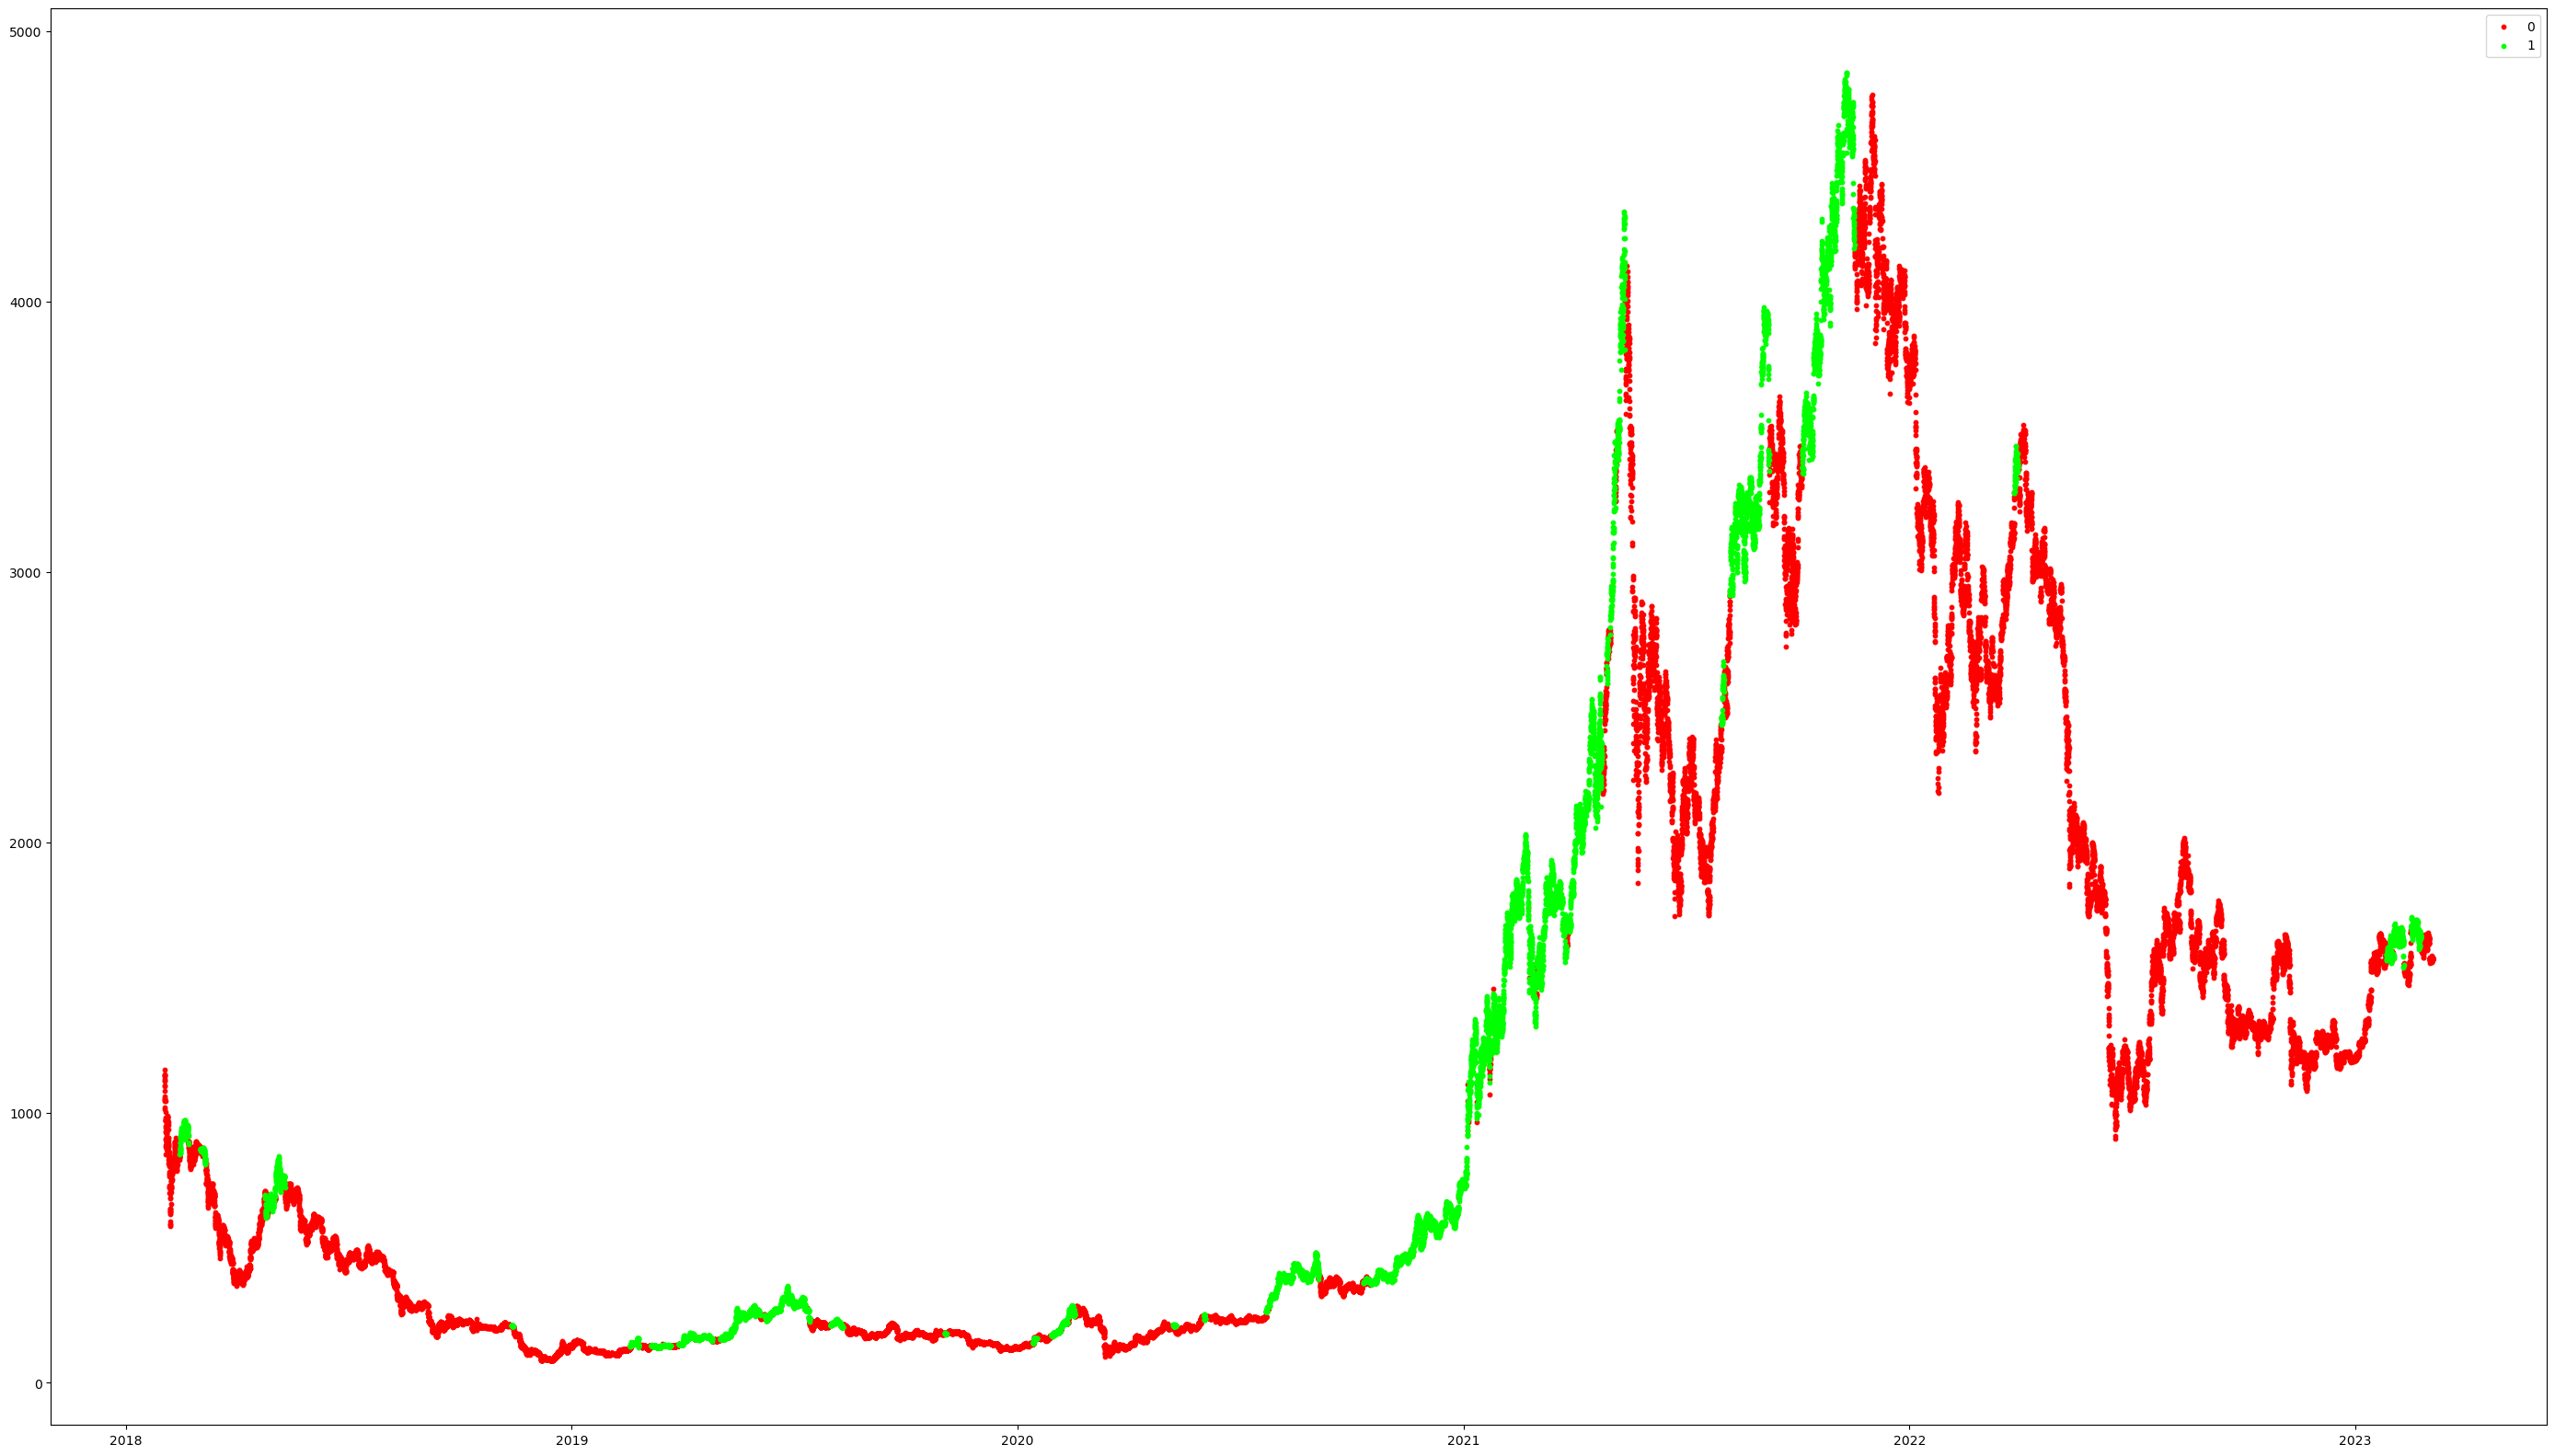

In [504]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 20))
for label, color in zip(df_eda['signal'].unique(), ['red','lime']):
    mask = df_eda['signal'] == label
    ax.scatter(df_eda.index[mask], df_eda['close'][mask], label=label, c=color, s=10)
ax.legend()
plt.show()

In [505]:
# Display the plot inline in Jupyter Lab
%matplotlib inline

# Plot the time series with clusters in different colors
plot = df_encoded.hvplot.scatter(x='index', y='close',  c='cluster', legend='top_left', height=500, width=1000, title='Clusters of Time Series')

# Show the plot in Jupyter notebook
plot

:Scatter   [index]   (close,cluster)

In [506]:
# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = 500

# Buy a 500 share position when the dual moving average crossover Signal equals 1
# Otherwise, `Position` should be zero (sell)
df_eda['Position'] = share_size * df_eda['signal']

# Determine the points in time where a 500 share position is bought or sold
df_eda['Entry/Exit Position'] = df_eda['Position'].diff()

# Multiply the close price by the number of shares held, or the Position
df_eda['Portfolio Holdings'] = df_eda['close'] * df_eda['Position']

# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
df_eda['Portfolio Cash'] = initial_capital - (df_eda['close'] * df_eda['Entry/Exit Position']).cumsum() 

# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
df_eda['Portfolio Total'] = df_eda['Portfolio Cash'] + df_eda['Portfolio Holdings']

# Calculate the portfolio daily returns
df_eda['Portfolio Daily Returns'] = df_eda['Portfolio Total'].pct_change()

# Calculate the portfolio cumulative returns
df_eda['Portfolio Cumulative Returns'] = (1 + df_eda['Portfolio Daily Returns']).cumprod() - 1




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [507]:
# Visualize the value of the total portfolio
total_portfolio_value = df_eda[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1000,
    height=400
)


In [509]:
total_portfolio_value

:Curve   [index]   (Portfolio Total)

In [510]:
df_eda.head()

volume       ADX_5  fng_Fear  fng_Greed  \
2018-02-01 05:00:00   3462.28586  100.000000         1          0   
2018-02-01 06:00:00   3400.69303   50.133579         1          0   
2018-02-01 07:00:00   2589.27888   39.437213         1          0   
2018-02-01 08:00:00  12753.77711   53.920963         1          0   
2018-02-01 09:00:00   8388.78259   62.331328         1          0   

                     fng_Hi_Fear  fng_Hi_Greed  fng_Neutral  cluster    close  \
2018-02-01 05:00:00            0             0            0        0  1159.13   
2018-02-01 06:00:00            0             0            0        0  1142.99   
2018-02-01 07:00:00            0             0            0        0  1137.10   
2018-02-01 08:00:00            0             0            0        0  1123.30   
2018-02-01 09:00:00            0             0            0        0  1101.74   

                     actual_returns  fng_value fng_classification  signal  \
2018-02-01 05:00:00        0.005744         30               Fear       0   
2018-02-01 06:00:00       -0.013924         30               Fear       0   
2018-02-01 07:00:00       -0.005153         30               Fear       0   
2018-02-01 08:00:00       -0.012136         30               Fear       0   
2018-02-01 09:00:00       -0.019193         30               Fear       0   

                     Position  Entry/Exit Position  Portfolio Holdings  \
2018-02-01 05:00:00         0                  NaN                 0.0   
2018-02-01 06:00:00         0                  0.0                 0.0   
2018-02-01 07:00:00         0                  0.0                 0.0   
2018-02-01 08:00:00         0                  0.0                 0.0   
2018-02-01 09:00:00         0                  0.0                 0.0   

                     Portfolio Cash  Portfolio Total  Portfolio Daily Returns  \
2018-02-01 05:00:00             NaN              NaN                      NaN   
2018-02-01 06:00:00        100000.0         100000.0                      NaN   
2018-02-01 07:00:00        100000.0         100000.0                      0.0   
2018-02-01 08:00:00        100000.0         100000.0                      0.0   
2018-02-01 09:00:00        100000.0         100000.0                      0.0   

                     Portfolio Cumulative Returns  
2018-02-01 05:00:00                           NaN  
2018-02-01 06:00:00                           NaN  
2018-02-01 07:00:00                           0.0  
2018-02-01 08:00:00                           0.0  
2018-02-01 09:00:00                           0.0

---
## 2ND Feat Engineering

In [511]:
import finta as ft
from finta import TA
import talib

prep_df = df_eng.copy()
prep_df['signal'] = df_eda['signal']


In [512]:
prep_df.columns

Index(['fng_value', 'fng_classification', 'open', 'high', 'low', 'close',
       'volume', 'actual_returns', 'SMA_5', 'EMA_5', 'HMA_5', 'VAMA_5',
       'ATR_5', 'ADX_5', 'RSI_5', 'SMA_7', 'EMA_7', 'HMA_7', 'VAMA_7', 'ATR_7',
       'ADX_7', 'RSI_7', 'SMA_14', 'EMA_14', 'HMA_14', 'VAMA_14', 'ATR_14',
       'ADX_14', 'RSI_14', 'SMA_20', 'EMA_20', 'HMA_20', 'VAMA_20', 'ATR_20',
       'ADX_20', 'RSI_20', 'SMA_30', 'EMA_30', 'HMA_30', 'VAMA_30', 'ATR_30',
       'ADX_30', 'RSI_30', 'SMA_50', 'EMA_50', 'HMA_50', 'VAMA_50', 'ATR_50',
       'ADX_50', 'RSI_50', 'SMA_70', 'EMA_70', 'HMA_70', 'VAMA_70', 'ATR_70',
       'ADX_70', 'RSI_70', 'SMA_100', 'EMA_100', 'HMA_100', 'VAMA_100',
       'ATR_100', 'ADX_100', 'RSI_100', 'SMA_150', 'EMA_150', 'HMA_150',
       'VAMA_150', 'ATR_150', 'ADX_150', 'RSI_150', 'SMA_200', 'EMA_200',
       'HMA_200', 'VAMA_200', 'ATR_200', 'ADX_200', 'RSI_200', 'UO', 'AO',
       'OBV', 'CHAIKIN', 'BB_UPPER', 'BB_MED', 'BB_LOWER', 'cci', 'tenkan_sen',
       'kiju

In [513]:
# Dummy-encoding process 
# create a list of categorical columns
cat_cols = ['fng_classification']

# use the get_dummies function to dummy encode the categorical columns
dummy_cols = pd.get_dummies(prep_df[cat_cols], prefix=cat_cols, drop_first=True)

# concatenate the dummy columns with the original dataframe
prep_df = pd.concat([prep_df.drop(cat_cols, axis=1), dummy_cols], axis=1)

In [514]:
prep_df['signal'].value_counts()

0.0    32354
1.0    12138
Name: signal, dtype: int64

___
### 3.5 Class Imbalance

In [515]:
import pandas as pd
from sklearn.utils import resample

# Count the number of samples in each class
class_counts = prep_df['signal'].value_counts()

# Find the class with fewer samples
minority_class = class_counts.idxmin()

# Split the dataframe into the majority and minority classes
majority_class = prep_df[prep_df['signal'] != minority_class]
minority_class = prep_df[prep_df['signal'] == minority_class]

# Undersample the majority class to match the number of samples in the minority class
undersampled_majority = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

# Combine the undersampled majority class with the minority class
balanced_df = pd.concat([undersampled_majority, minority_class])

# Shuffle the rows in the balanced dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42)

In [516]:
balanced_df["signal"].value_counts()

1.0    12138
0.0    12136
Name: signal, dtype: int64

In [517]:
# Creating X as predictors (features) dataset
X= balanced_df.copy()

# sort X by index
X = X.sort_index(axis=0)

# Removing columns indicative of previous prices
# & shifting X one row down to avoid using data not available to us at the time of prediction
X= X.drop(["open","high","low","close","volume","actual_returns","signal"], axis =1).shift().dropna().copy()

In [518]:
X

fng_value     SMA_5        EMA_5        HMA_5  \
2018-02-19 00:00:00       63.0   927.274   922.858166   907.645333   
2018-02-19 01:00:00       67.0   922.698   922.492111   912.577333   
2018-02-19 02:00:00       67.0   921.598   924.661407   926.347333   
2018-02-19 03:00:00       67.0   921.030   925.074271   930.762222   
2018-02-19 04:00:00       67.0   921.818   923.859514   925.075333   
...                        ...       ...          ...          ...   
2023-03-04 10:00:00       50.0  1569.446  1569.341209  1569.151556   
2023-03-04 11:00:00       50.0  1568.858  1568.673692  1568.484889   
2023-03-04 14:00:00       50.0  1568.670  1568.862461  1568.650667   
2023-03-04 15:00:00       50.0  1568.796  1568.565914  1567.473778   
2023-03-04 23:00:00       50.0  1567.590  1566.333943  1562.875111   

                          VAMA_5   ATR_5      ADX_5      RSI_5        SMA_7  \
2018-02-19 00:00:00   924.694386  13.798  35.752063  23.500363   930.428571   
2018-02-19 01:00:00   921.344398  14.604  35.746290  43.379263   928.037143   
2018-02-19 02:00:00   920.455745  14.960  30.276940  53.534689   926.732857   
2018-02-19 03:00:00   919.645504  15.058  26.330905  48.845672   924.055714   
2018-02-19 04:00:00   920.219095  14.240  23.174078  42.185762   922.188571   
...                          ...     ...        ...        ...          ...   
2023-03-04 10:00:00  1569.186158   4.906  27.868870  47.974870  1570.037143   
2023-03-04 11:00:00  1568.928960   3.944  28.940322  44.020928  1568.810000   
2023-03-04 14:00:00  1568.674571   3.046  29.896279  52.170570  1568.645714   
2023-03-04 15:00:00  1568.792527   3.894  23.016763  40.069320  1568.765714   
2023-03-04 23:00:00  1567.128154   4.444  30.476472  23.262046  1567.895714   

                           EMA_7  ...         cci  tenkan_sen  kijun_sen  \
2018-02-19 00:00:00   925.527553  ... -133.569399     928.270     937.75   
2018-02-19 01:00:00   924.585665  ...  -91.552291     925.740     937.75   
2018-02-19 02:00:00   925.689249  ...   -4.313610     925.740     937.75   
2018-02-19 03:00:00   925.741936  ...  -42.381210     925.740     937.75   
2018-02-19 04:00:00   924.663952  ...  -40.287643     925.740     937.75   
...                          ...  ...         ...         ...        ...   
2023-03-04 10:00:00  1569.316488  ...   26.928642    1570.120    1564.04   
2023-03-04 11:00:00  1568.791019  ...   15.617573    1567.910    1564.04   
2023-03-04 14:00:00  1568.903264  ...   25.409664    1567.810    1564.04   
2023-03-04 15:00:00  1568.716064  ...   -4.424463    1568.925    1564.04   
2023-03-04 23:00:00  1567.004548  ...  -96.192288    1566.880    1564.04   

                     senkou_span_a  senkou_span_b  chikou_span  \
2018-02-19 00:00:00       957.7800        937.680       951.59   
2018-02-19 01:00:00       958.4350        937.680       942.70   
2018-02-19 02:00:00       959.1200        937.680       945.06   
2018-02-19 03:00:00       959.1200        937.680       946.53   
2018-02-19 04:00:00       961.3700        939.680       947.93   
...                            ...            ...          ...   
2023-03-04 10:00:00      1601.1950       1611.125      1568.67   
2023-03-04 11:00:00      1599.0075       1611.125      1569.40   
2023-03-04 14:00:00      1597.6025       1611.125      1572.69   
2023-03-04 15:00:00      1585.0900       1611.125      1570.26   
2023-03-04 23:00:00      1584.8675       1611.125      1568.60   

                     fng_classification_Extreme Greed  \
2018-02-19 00:00:00                               0.0   
2018-02-19 01:00:00                               0.0   
2018-02-19 02:00:00                               0.0   
2018-02-19 03:00:00                               0.0   
2018-02-19 04:00:00                               0.0   
...                                               ...   
2023-03-04 10:00:00                               0.0   
2023-03-04 11:00:00                               0.0   
2023-03-04 1

In [519]:
# Copy the new signal column to a new Series called y.
y = balanced_df["signal"].copy()

# keeping y and X the same size 
y = y[X.index]

In [520]:
y

2018-02-19 00:00:00    1.0
2018-02-19 01:00:00    1.0
2018-02-19 02:00:00    1.0
2018-02-19 03:00:00    1.0
2018-02-19 04:00:00    1.0
                      ... 
2023-03-04 10:00:00    0.0
2023-03-04 11:00:00    0.0
2023-03-04 14:00:00    0.0
2023-03-04 15:00:00    0.0
2023-03-04 23:00:00    0.0
Name: signal, Length: 23998, dtype: float64

---
## ML Scaler

In [521]:
from sklearn.preprocessing import StandardScaler

# Scale the data
MLscaler = StandardScaler()
X_scaled = MLscaler.fit_transform(X)

# Convert the scaled numpy array back to a pandas DataFrame
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

In [522]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Scale the data
X_scaled = scaler.fit_transform(X)

# Convert X_scaled back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Create a logistic regression model
model = LogisticRegression(max_iter=200)

# Create an RFE model to select the best features
rfe = RFE(model, n_features_to_select=25)

# Fit the RFE model to the data
rfe = rfe.fit(X_scaled, y)

# Get the selected features
selected_features = X_scaled.columns[rfe.support_]

# Keep only specified columns in the dataframe
X_scaled = X_scaled[selected_features]

# Print the selected features
print("Number of selected features:", len(X_scaled.columns), "\nSelected features:\n", selected_features)


Number of selected features: 25 
Selected features:
 Index(['fng_value', 'ATR_5', 'ATR_7', 'ADX_7', 'VAMA_14', 'ATR_14', 'ADX_14',
       'RSI_14', 'HMA_30', 'ATR_30', 'RSI_50', 'ADX_70', 'ATR_100', 'ADX_100',
       'RSI_100', 'ADX_150', 'ATR_200', 'ADX_200', 'RSI_200', 'OBV',
       'BB_LOWER', 'chikou_span', 'fng_classification_Extreme Greed',
       'fng_classification_Fear', 'fng_classification_Greed'],
      dtype='object')


In [523]:
df_lo_feats = X[selected_features].copy()
#df_lo_feats = df_lo_feats.drop(["fng_value"], axis =1)
# Calculate correlation matrix
# calculate the correlation matrix of the features
corr_matrix = df_lo_feats.corr()

# set the threshold for correlation value
corr_threshold = 0.90

# find the highly correlated features and drop them from the dataframe
high_corr_features = np.where(corr_matrix.abs() > corr_threshold)
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
df_lo_feats.drop([col[1] for col in high_corr_features], axis=1, inplace=True)

# select the remaining features with low correlation
low_corr_features = df_lo_feats.columns.tolist()

# print the low correlated features
print(low_corr_features)

['fng_value', 'ATR_5', 'ADX_7', 'VAMA_14', 'ADX_14', 'RSI_14', 'RSI_50', 'ADX_70', 'fng_classification_Extreme Greed', 'fng_classification_Fear', 'fng_classification_Greed']


In [524]:
X=df_lo_feats[low_corr_features]
#X = X[selected_features]

In [525]:
# Imports 
from pandas.tseries.offsets import DateOffset

# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
#print(training_begin)

# Select the ending period for the training data with an offset of 36 months
training_end = X.index.min() + DateOffset(months=36)

# Display the training end date
#print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
display(X_train.head())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
display(X_test.head())

fng_value   ATR_5      ADX_7     VAMA_14     ADX_14  \
2018-02-19 00:00:00       63.0  13.798  29.423693  929.617808  29.649740   
2018-02-19 01:00:00       67.0  14.604  30.066872  929.705936  29.863317   
2018-02-19 02:00:00       67.0  14.960  25.773284  929.688758  28.865432   
2018-02-19 03:00:00       67.0  15.058  23.947030  929.430635  28.331690   
2018-02-19 04:00:00       67.0  14.240  22.381670  928.178801  27.836072   

                        RSI_14     RSI_50    ADX_70  \
2018-02-19 00:00:00  37.872879  47.512581  7.888682   
2018-02-19 01:00:00  43.785617  49.099413  7.945373   
2018-02-19 02:00:00  47.412245  50.134498  7.953663   
2018-02-19 03:00:00  46.042553  49.692983  7.982282   
2018-02-19 04:00:00  44.065748  49.057313  8.010486   

                     fng_classification_Extreme Greed  \
2018-02-19 00:00:00                               0.0   
2018-02-19 01:00:00                               0.0   
2018-02-19 02:00:00                               0.0   
2018-02-19 03:00:00                               0.0   
2018-02-19 04:00:00                               0.0   

                     fng_classification_Fear  fng_classification_Greed  
2018-02-19 00:00:00                      0.0                       1.0  
2018-02-19 01:00:00                      0.0                       1.0  
2018-02-19 02:00:00                      0.0                       1.0  
2018-02-19 03:00:00                      0.0                       1.0  
2018-02-19 04:00:00                      0.0                       1.0

fng_value   ATR_5      ADX_7      VAMA_14     ADX_14  \
2021-02-19 00:00:00       91.0  22.200  31.611458  1920.069629  34.475409   
2021-02-19 01:00:00       93.0  22.940  28.294744  1921.153164  33.516998   
2021-02-19 02:00:00       93.0  23.464  26.987983  1923.056881  31.357606   
2021-02-19 03:00:00       93.0  26.038  28.334919  1924.641114  29.842039   
2021-02-19 04:00:00       93.0  26.016  28.143234  1924.610835  28.130762   

                        RSI_14     RSI_50    ADX_70  \
2021-02-19 00:00:00  65.777695  59.476882  8.715597   
2021-02-19 01:00:00  60.266709  58.230615  8.712757   
2021-02-19 02:00:00  55.152609  56.978581  8.667423   
2021-02-19 03:00:00  54.977855  56.935132  8.584033   
2021-02-19 04:00:00  52.169629  56.244742  8.511868   

                     fng_classification_Extreme Greed  \
2021-02-19 00:00:00                               1.0   
2021-02-19 01:00:00                               1.0   
2021-02-19 02:00:00                               1.0   
2021-02-19 03:00:00                               1.0   
2021-02-19 04:00:00                               1.0   

                     fng_classification_Fear  fng_classification_Greed  
2021-02-19 00:00:00                      0.0                       0.0  
2021-02-19 01:00:00                      0.0                       0.0  
2021-02-19 02:00:00                      0.0                       0.0  
2021-02-19 03:00:00                      0.0                       0.0  
2021-02-19 04:00:00                      0.0                       0.0

In [526]:
## Scaler for ML pre-processing

In [527]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---
## 4. ML models 
#### 4.1 XGboost

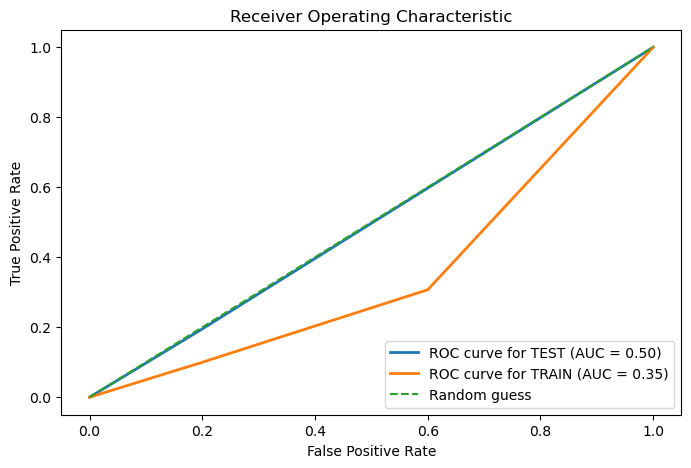

TRAINING classification report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      6845
         1.0       0.53      1.00      0.70      7857

    accuracy                           0.53     14702
   macro avg       0.27      0.50      0.35     14702
weighted avg       0.29      0.53      0.37     14702


TESTING classification report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5156
         1.0       0.45      1.00      0.62      4141

    accuracy                           0.45      9297
   macro avg       0.22      0.50      0.31      9297
weighted avg       0.20      0.45      0.27      9297

Test accuracy: 0.45
>> Test precision: 0.45 <<
Test recall: 0.45
Test F1 score: 0.45
Test AUC score: 0.50


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [529]:
import xgboost as xgb
#from xgboost import xgbClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

#replace -1 by 0 as xgboost expects a boolean target vector (only 0 and 1)
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

# Create a xgb Classifier model
xgb_clf = xgb.XGBClassifier(reg_alpha=1)

xgb_clf.fit(X_train_scaled, y_train) 

# Use the best model to make predictions on the test data
y_pred_xgb = xgb_clf.predict(X_test_scaled)

ROC(xgb_clf,X_train,X_test,y_train,y_test)

<Axes: >

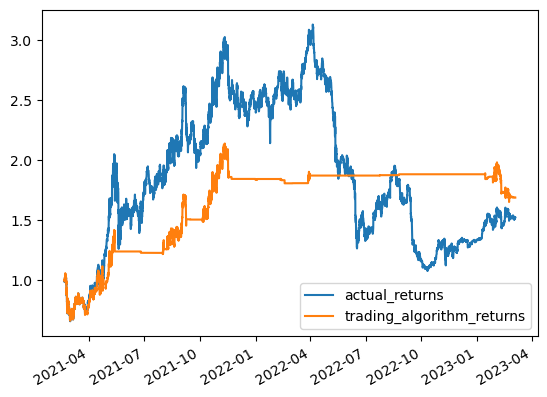

In [531]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = xgb_clf

# Backtest using our exteranl function
xgb_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + xgb_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

> The XGB results appear to be too good to be true - the classification report are very weird as well --> not to use for production

In [532]:
X_test.columns


Index(['fng_value', 'ATR_5', 'ADX_7', 'VAMA_14', 'ADX_14', 'RSI_14', 'RSI_50',
       'ADX_70', 'fng_classification_Extreme Greed', 'fng_classification_Fear',
       'fng_classification_Greed'],
      dtype='object')

---
#### 4.2 CatBoost

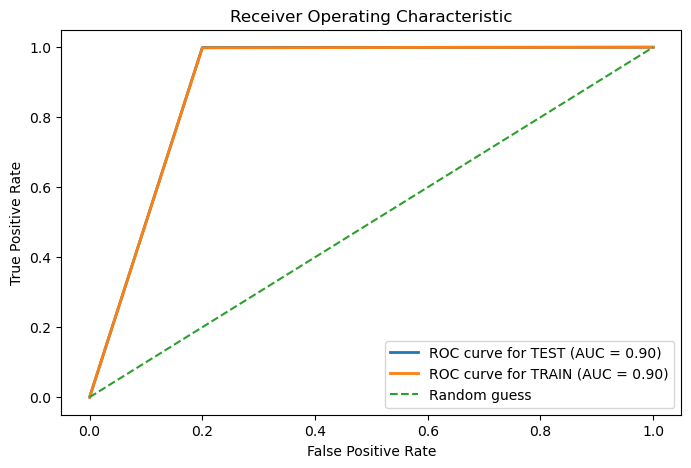

TRAINING classification report: 
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      6845
         1.0       0.99      1.00      1.00      7857

    accuracy                           0.99     14702
   macro avg       0.99      0.99      0.99     14702
weighted avg       0.99      0.99      0.99     14702


TESTING classification report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5156
         1.0       1.00      1.00      1.00      4141

    accuracy                           1.00      9297
   macro avg       1.00      1.00      1.00      9297
weighted avg       1.00      1.00      1.00      9297

Test accuracy: 1.00
>> Test precision: 1.00 <<
Test recall: 1.00
Test F1 score: 1.00
Test AUC score: 0.90


In [658]:
# Import libraries
from catboost import CatBoostClassifier
# Initialize the CatBoost model

cb_clf = CatBoostClassifier(
    iterations=300,
    learning_rate=0.005,
    #depth=5,
    l2_leaf_reg=500,  # L2 regularization parameter
    verbose=False
)

# Train the model on the training data
cb_clf.fit(X_train_scaled, y_train)

# display ROC and classification metrics 
ROC(cb_clf,X_train_scaled, X_test_scaled, y_train, y_test)


<Axes: >

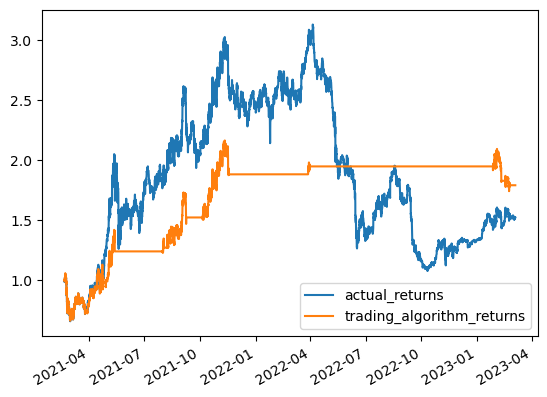

In [659]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = cb_clf

# Backtest using our exteranl function
cb_predictions_df = Backtesting (df_eda, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + cb_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---
#### 4.3 LDA

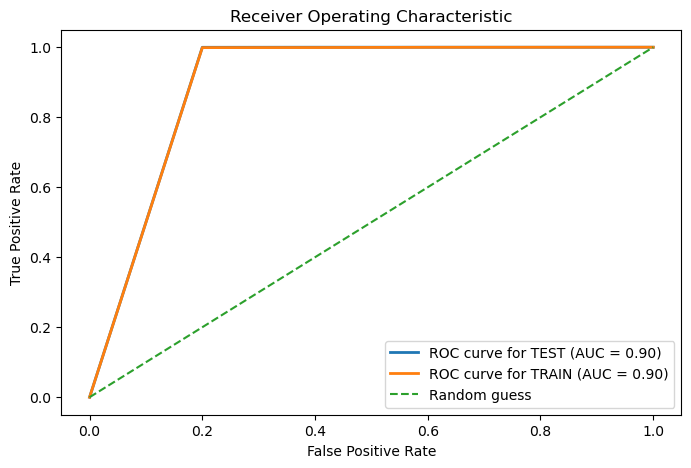

TRAINING classification report: 
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      6845
         1.0       0.99      1.00      1.00      7857

    accuracy                           0.99     14702
   macro avg       0.99      0.99      0.99     14702
weighted avg       0.99      0.99      0.99     14702


TESTING classification report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5156
         1.0       1.00      1.00      1.00      4141

    accuracy                           1.00      9297
   macro avg       1.00      1.00      1.00      9297
weighted avg       1.00      1.00      1.00      9297

Test accuracy: 1.00
>> Test precision: 1.00 <<
Test recall: 1.00
Test F1 score: 1.00
Test AUC score: 0.90


In [535]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# create LDA object and fit the model
lda = LinearDiscriminantAnalysis()

# Train the model on the training data
lda.fit_transform(X_train_scaled, y_train)

ROC(lda,X_train_scaled, X_test_scaled, y_train, y_test)

<Axes: >

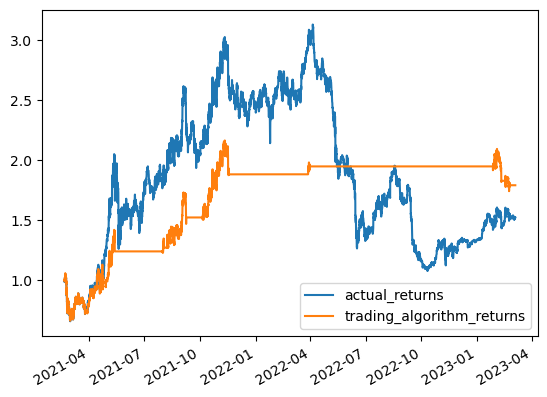

In [536]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = lda

# Backtest using our exteranl function
lda_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lda_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

## 4.4 Gradient Boosting Tree Classifier

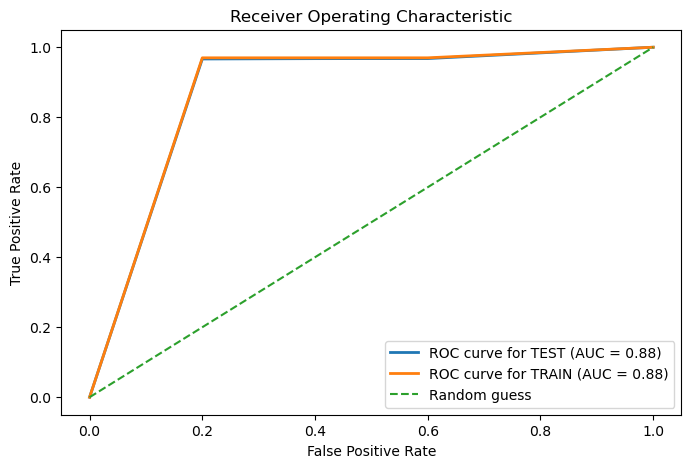

TRAINING classification report: 
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      6845
         1.0       0.99      0.97      0.98      7857

    accuracy                           0.98     14702
   macro avg       0.97      0.98      0.98     14702
weighted avg       0.98      0.98      0.98     14702


TESTING classification report: 
               precision    recall  f1-score   support

         0.0       0.97      0.76      0.85      5156
         1.0       0.77      0.97      0.86      4141

    accuracy                           0.85      9297
   macro avg       0.87      0.87      0.85      9297
weighted avg       0.88      0.85      0.85      9297

Test accuracy: 0.85
>> Test precision: 0.85 <<
Test recall: 0.85
Test F1 score: 0.85
Test AUC score: 0.88


In [668]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Initialize the model with regularization
gbt_clf = GradientBoostingClassifier(learning_rate = 0.5, subsample = 0.5, 
                                     max_depth=5, min_samples_split=4, 
                                     min_samples_leaf=2, max_leaf_nodes=None, random_state=seed)

# Train the model on the training data
gbt_clf.fit(X_train_scaled, y_train)

ROC(gbt_clf,X_train_scaled, X_test_scaled, y_train, y_test)


<Axes: >

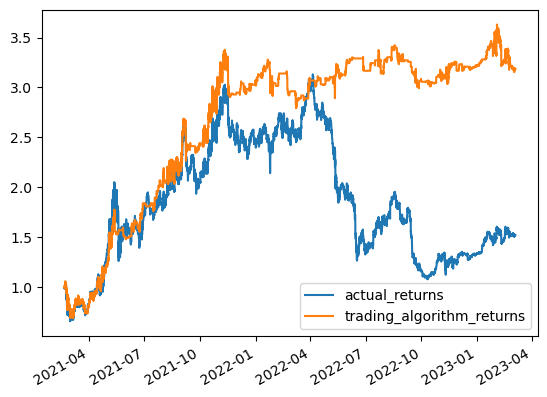

In [672]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = gbt_clf

# Backtest using our exteranl function
gbt_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + gbt_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [673]:
display (df_eda.head())
display (gbt_predictions_df.head())

volume       ADX_5  fng_Fear  fng_Greed  \
2018-02-01 05:00:00   3462.28586  100.000000         1          0   
2018-02-01 06:00:00   3400.69303   50.133579         1          0   
2018-02-01 07:00:00   2589.27888   39.437213         1          0   
2018-02-01 08:00:00  12753.77711   53.920963         1          0   
2018-02-01 09:00:00   8388.78259   62.331328         1          0   

                     fng_Hi_Fear  fng_Hi_Greed  fng_Neutral  cluster    close  \
2018-02-01 05:00:00            0             0            0        0  1159.13   
2018-02-01 06:00:00            0             0            0        0  1142.99   
2018-02-01 07:00:00            0             0            0        0  1137.10   
2018-02-01 08:00:00            0             0            0        0  1123.30   
2018-02-01 09:00:00            0             0            0        0  1101.74   

                     actual_returns  fng_value fng_classification  signal  \
2018-02-01 05:00:00        0.005744         30               Fear       0   
2018-02-01 06:00:00       -0.013924         30               Fear       0   
2018-02-01 07:00:00       -0.005153         30               Fear       0   
2018-02-01 08:00:00       -0.012136         30               Fear       0   
2018-02-01 09:00:00       -0.019193         30               Fear       0   

                     Position  Entry/Exit Position  Portfolio Holdings  \
2018-02-01 05:00:00         0                  NaN                 0.0   
2018-02-01 06:00:00         0                  0.0                 0.0   
2018-02-01 07:00:00         0                  0.0                 0.0   
2018-02-01 08:00:00         0                  0.0                 0.0   
2018-02-01 09:00:00         0                  0.0                 0.0   

                     Portfolio Cash  Portfolio Total  Portfolio Daily Returns  \
2018-02-01 05:00:00             NaN              NaN                      NaN   
2018-02-01 06:00:00        100000.0         100000.0                      NaN   
2018-02-01 07:00:00        100000.0         100000.0                      0.0   
2018-02-01 08:00:00        100000.0         100000.0                      0.0   
2018-02-01 09:00:00        100000.0         100000.0                      0.0   

                     Portfolio Cumulative Returns  
2018-02-01 05:00:00                           NaN  
2018-02-01 06:00:00                           NaN  
2018-02-01 07:00:00                           0.0  
2018-02-01 08:00:00                           0.0  
2018-02-01 09:00:00                           0.0

predicted_signal  actual_returns  \
2021-02-19 00:00:00               1.0       -0.005769   
2021-02-19 01:00:00               1.0       -0.005963   
2021-02-19 02:00:00               1.0       -0.000209   
2021-02-19 03:00:00               1.0       -0.003292   
2021-02-19 04:00:00               1.0       -0.003638   

                     trading_algorithm_returns  
2021-02-19 00:00:00                        NaN  
2021-02-19 01:00:00                  -0.005963  
2021-02-19 02:00:00                  -0.000209  
2021-02-19 03:00:00                  -0.003292  
2021-02-19 04:00:00                  -0.003638

In [674]:
display(len(df_eda),len(gbt_predictions_df))

44492

9297

In [675]:
df = gbt_predictions_df

In [676]:
df['close'] = df_eda['close']

In [677]:
# Rename column 'predicted_signal' to 'gbt_prediction'
df = df.rename(columns={'predicted_signal': 'gbt_prediction'})

In [678]:
df.head()

gbt_prediction  actual_returns  \
2021-02-19 00:00:00             1.0       -0.005769   
2021-02-19 01:00:00             1.0       -0.005963   
2021-02-19 02:00:00             1.0       -0.000209   
2021-02-19 03:00:00             1.0       -0.003292   
2021-02-19 04:00:00             1.0       -0.003638   

                     trading_algorithm_returns    close  
2021-02-19 00:00:00                        NaN  1928.42  
2021-02-19 01:00:00                  -0.005963  1916.92  
2021-02-19 02:00:00                  -0.000209  1916.52  
2021-02-19 03:00:00                  -0.003292  1910.21  
2021-02-19 04:00:00                  -0.003638  1903.26

In [679]:
import pandas as pd
import numpy as np
import hvplot.pandas

# Assuming df is already loaded with 'close' and 'gbt_prediction' columns
initial_capital = 10000
duration_dca_buy = 3
duration_dca_sell = 1

# Add new columns to store calculations
df['eth_owned'] = 0.0
df['current_usd_capital'] = initial_capital
df['algo_value'] = 0.0
df['dca_value'] = 0.0

# Initialize the remaining buy and sell duration
remaining_buy_duration = duration_dca_buy
remaining_sell_duration = 0

# Loop through each row in the dataset
for i in range(1, len(df)):
    eth_owned = df.loc[df.index[i - 1], 'eth_owned']
    current_usd_capital = df.loc[df.index[i - 1], 'current_usd_capital']
    
    if df.loc[df.index[i], 'gbt_prediction'] == 1:
        if remaining_buy_duration > 0:
            # Calculate the daily_buy_amount based on the remaining buy duration
            daily_buy_amount = current_usd_capital / remaining_buy_duration
            remaining_buy_duration -= 1
        else:
            daily_buy_amount = 0

        # Buy using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_buy = daily_buy_amount / df.loc[df.index[i], 'close']
            eth_owned += eth_to_buy
            current_usd_capital -= daily_buy_amount
        
            # Update daily_sell_amount
            daily_sell_amount = (eth_owned * df.loc[df.index[i], 'close']) / duration_dca_sell
        
    elif df.loc[df.index[i], 'gbt_prediction'] == 0 and eth_owned > 0:
        # Reset remaining_buy_duration
        remaining_buy_duration = duration_dca_buy
        
        # Sell using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_sell = daily_sell_amount / df.loc[df.index[i], 'close']
            eth_owned -= eth_to_sell
            current_usd_capital += daily_sell_amount

    df.loc[df.index[i], 'eth_owned'] = eth_owned
    df.loc[df.index[i], 'current_usd_capital'] = current_usd_capital
    df.loc[df.index[i], 'algo_value'] = eth_owned * df.loc[df.index[i], 'close'] + current_usd_capital
    
    # Update DCA value
    if df.loc[df.index[i], 'close'] > 0:
        dca_eth_to_buy = daily_buy_amount / df.loc[df.index[i], 'close']
        df.loc[df.index[i], 'dca_value'] = df.loc[df.index[i - 1], 'dca_value'] + (dca_eth_to_buy * df.loc[df.index[i], 'close'])

In [680]:


# Plot the results
plot = df[['algo_value']].hvplot.line(title='Algo-Trading Strategy vs. DCA', width=1000, height=400)
plot


:Curve   [index]   (algo_value)

In [681]:
import pandas as pd
import numpy as np
import hvplot.pandas

# Assuming df is already loaded with 'close' and 'gbt_prediction' columns
initial_capital = 10000
duration_dca_buy = 4
duration_dca_sell = 1

# Add new columns to store calculations
df['eth_owned'] = 0.0
df['current_usd_capital'] = initial_capital
df['algo_value'] = 0.0
df['dca_value'] = 0.0
df['dca_eth_owned'] = 0.0

# Initialize the remaining buy and sell duration
remaining_buy_duration = duration_dca_buy
remaining_sell_duration = 0

# Calculate the daily_buy_amount for DCA strategy
daily_dca_buy_amount = initial_capital / duration_dca_buy

# Loop through each row in the dataset
for i in range(1, len(df)):
    eth_owned = df.loc[df.index[i - 1], 'eth_owned']
    current_usd_capital = df.loc[df.index[i - 1], 'current_usd_capital']
    dca_eth_owned = df.loc[df.index[i - 1], 'dca_eth_owned']
    
    if df.loc[df.index[i], 'gbt_prediction'] == 1:
        if remaining_buy_duration > 0:
            # Calculate the daily_buy_amount based on the remaining buy duration
            daily_buy_amount = current_usd_capital / remaining_buy_duration
            remaining_buy_duration -= 1
        else:
            daily_buy_amount = 0

        # Buy using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_buy = daily_buy_amount / df.loc[df.index[i], 'close']
            eth_owned += eth_to_buy
            current_usd_capital -= daily_buy_amount
        
            # Update daily_sell_amount
            daily_sell_amount = (eth_owned * df.loc[df.index[i], 'close']) / duration_dca_sell
        
    elif df.loc[df.index[i], 'gbt_prediction'] == 0 and eth_owned > 0:
        # Reset remaining_buy_duration
        remaining_buy_duration = duration_dca_buy
        
        # Sell using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_sell = daily_sell_amount / df.loc[df.index[i], 'close']
            eth_owned -= eth_to_sell
            current_usd_capital += daily_sell_amount

    df.loc[df.index[i], 'eth_owned'] = eth_owned
    df.loc[df.index[i], 'current_usd_capital'] = current_usd_capital
    df.loc[df.index[i], 'algo_value'] = eth_owned * df.loc[df.index[i], 'close'] + current_usd_capital
    
    # Update DCA value and DCA ETH holdings
    if df.loc[df.index[i], 'close'] > 0:
        if initial_capital > 0:
            dca_eth_to_buy = daily_dca_buy_amount / df.loc[df.index[i], 'close']
            dca_eth_owned += dca_eth_to_buy
            initial_capital -= daily_dca_buy_amount
        else:
            dca_eth_to_buy = 0
            daily_dca_buy_amount = 0

        df.loc[df.index[i], 'dca_eth_owned'] = dca_eth_owned
        df.loc[df.index[i], 'dca_value'] = dca_eth_owned * df.loc[df.index[i], 'close']




In [682]:

# Plot the results
plot = df[['algo_value','dca_value']].hvplot.line(title='Algo-Trading with DCA_Strategy vs. DCA-ETH', width=1000, height=400)
plot


:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [683]:
plot = (1 + gbt_predictions_df[["trading_algorithm_returns", "actual_returns"]]).cumprod().hvplot.line(title='ETH HODL returns vs Algo-Trading w/o DCA',width=1100, height=400)
plot

:NdOverlay   [Variable]
   :Curve   [index]   (value)

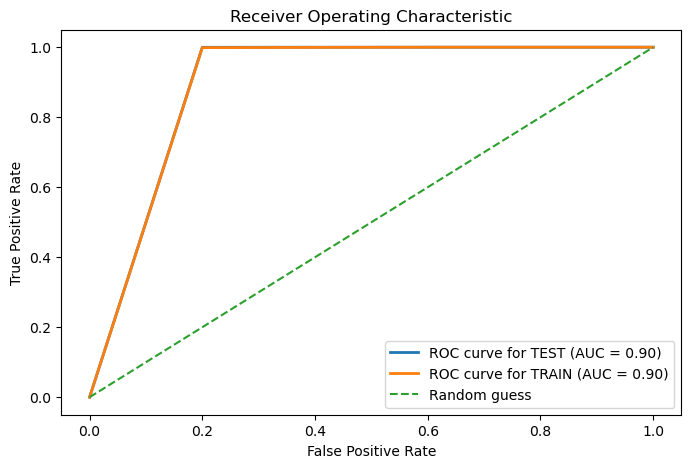

TRAINING classification report: 
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      6845
         1.0       0.99      1.00      1.00      7857

    accuracy                           0.99     14702
   macro avg       0.99      0.99      0.99     14702
weighted avg       0.99      0.99      0.99     14702


TESTING classification report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5156
         1.0       0.99      1.00      0.99      4141

    accuracy                           1.00      9297
   macro avg       1.00      1.00      1.00      9297
weighted avg       1.00      1.00      1.00      9297

Test accuracy: 1.00
>> Test precision: 1.00 <<
Test recall: 1.00
Test F1 score: 1.00
Test AUC score: 0.90


In [631]:
# create the logistic regression model
lr_model = LogisticRegression()

# fit the model on the training data
lr_model.fit(X_train_scaled, y_train)

# display ROC curve and classification results
ROC(lr_model,X_train_scaled,X_test_scaled,y_train,y_test)

<Axes: >

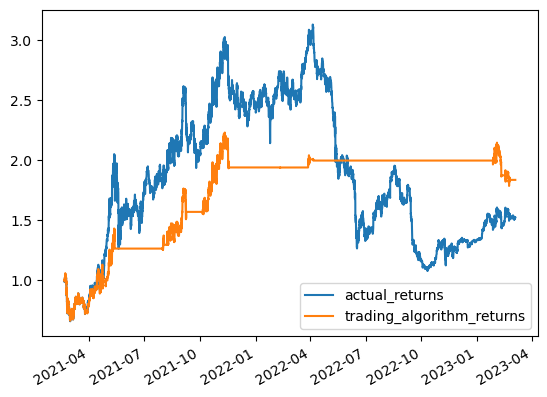

In [632]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = lr_model

# Backtest using our exteranl function
lr_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [329]:
## Adding Short and Long strategy 

<Axes: >

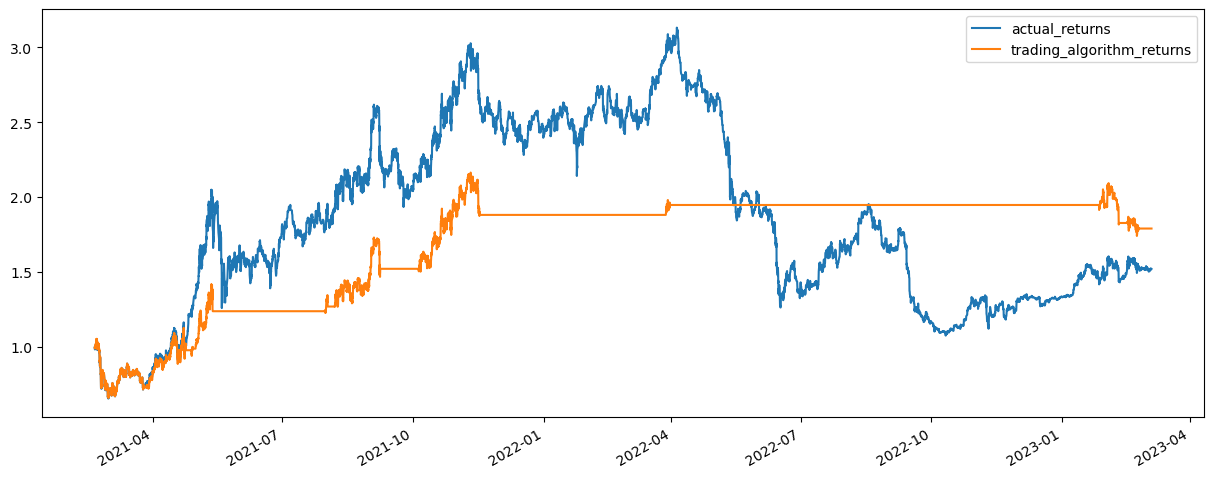

In [330]:
lr_predictions_df['futures_predicted'] = lr_predictions_df['trading_algorithm_returns'].replace(0,-1)
lr_predictions_df['Strategy_Returns'] = lr_predictions_df["actual_returns"] * lr_predictions_df["futures_predicted"]

# Plot the actual returns versus the strategy returns
(1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(figsize=(15,6))

---
## 5 Model Building helpers

These utilities below are helpful for identifying the best models and understanding them better. However, they may take a long time to run. If needed, you can interrupt their execution as they are not essential for the machine learning process.

### Selecting best performing model 

In [231]:
model_selection(X_test_scaled,y_test)

Model Name  F1_Mean  F1_Standard Deviation
0  LinearDiscriminantAnalysis     1.00                  0.002
1        KNeighborsClassifier     1.00                  0.002
2      DecisionTreeClassifier     0.99                  0.003
3      RandomForestClassifier     1.00                  0.002
4        ExtraTreesClassifier     1.00                  0.002
5          AdaBoostClassifier     0.99                  0.002
6                         SVM     1.00                  0.002
7  GradientBoostingClassifier     1.00                  0.002
8                     XGBoost     1.00                  0.002

### SHAP Analysis 

In [ ]:
# Resample X_test
upscaled_X_test = X_test.resample('1D').interpolate(method='linear')


In [ ]:
# define which classifier to use 
clf = xgb_clf


# Initialize SHAP explainer
explainer = shap.Explainer(clf.predict, upscaled_X_test)

# Calculate SHAP values
shap_values = explainer(upscaled_X_test)

shap.summary_plot(shap_values, upscaled_X_test, plot_type="bar")

In [ ]:
# SHAP Analysis 
# define which classifier to use 
clf = cb_clf

# Initialize SHAP explainer
explainer = shap.Explainer(clf.predict, upscaled_X_test)

# Calculate SHAP values
shap_values = explainer(upscaled_X_test)

shap.summary_plot(shap_values, upscaled_X_test, plot_type="bar")